In [1]:
%pylab
%matplotlib inline

import h5py
import pandas as pd
import os
import gc

#import plotly.express as px
from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler

import Helper_Basic as hbasic
hbasic.set_plot_prop()
plt.ion()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Requirement for this script :

## Inputs :
1) H5/csv file with the mechanical data

2) AE catalog (csv) potentially with co-located mechanical data 

## Outputs :

1) Aligned, uniformally spaced, and time aggregated mechanical and AE rate/strain rate/work rate time series 

2) AE event catalog with data appended from the mechanical datasets (e.g. strain rate etc)

# Datafile with the raw deformation datasets & synchronised AE datasets 

a) Specify the path where the mechanical data is stored (in a h5 file)

b) Specify path to the AE data

In [2]:
path_data_folder = '../00_Data/Wet_Basalt_CO2/'
path_mechanical_data = path_data_folder+'co2_mechdata.csv'
path_AE_data = path_data_folder+'co2_events_with_mechdata.csv'
name_exp = 'CO2_Wet_Basalt'

## Location where the time series data (aggregated) is saved
path_to_save_out_time_series = '/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_' 

#######################################################################################
sample_length = 81.48


### Loading the Mechanical Data

In [3]:
data_def = pd.read_csv(path_mechanical_data)
data_def['Strain_ax'] = data_def['Disp_mm']/sample_length 
data_def['date'] = np.datetime64('2021-09-01')+pd.to_timedelta(data_def['t_def'],unit='s')
data_def['time_hr'] = (data_def['date'] - data_def['date'].iloc[0])/ np.timedelta64(3600, 's')
#data_def = data_def.drop_duplicates('date', 'last')
data_def = data_def.set_index('date')


In [5]:
data_def['Time_Since_Step_1'] = (data_def['time_hr'] - 24.0747).clip(0)
data_def['Time_Since_Step_2'] = (data_def['time_hr'] - 48.196).clip(0)
data_def['Time_Since_Step_3'] = (data_def['time_hr'] - 71.963).clip(0)


In [6]:
dt = np.gradient(data_def.time_hr)
dt_resamp = np.nanmean(dt)
print(dt_resamp)

sampling_rate = int(dt_resamp*3600)
if sampling_rate == 0 :
    sampling_rate = 1    

0.0002777777777777777


In [7]:
new_data_def = data_def.resample(str(sampling_rate)+'s',closed='left', label='right').mean().ffill()

In [8]:
print(np.where(new_data_def['Disp_mm'].isna() == True)[0])

[]


In [9]:
new_data_def

Disp_mm  Sig_diff_MPa   t_def  Strain_ax    time_hr  \
date                                                                       
2021-09-01 00:00:01  2.24559       15.9659       0   0.027560   0.000000   
2021-09-01 00:00:02  2.24559       16.3469       1   0.027560   0.000278   
2021-09-01 00:00:03  2.24700       16.3469       2   0.027577   0.000556   
2021-09-01 00:00:04  2.24700       16.3469       3   0.027577   0.000833   
2021-09-01 00:00:05  2.24700       16.3469       4   0.027577   0.001111   
...                      ...           ...     ...        ...        ...   
2021-09-04 00:53:58  3.20353       62.8269  262437   0.039317  72.899167   
2021-09-04 00:53:59  3.20636       62.8269  262438   0.039351  72.899444   
2021-09-04 00:54:00  3.21061       62.8269  262439   0.039404  72.899722   
2021-09-04 00:54:01  3.21344       62.8269  262440   0.039438  72.900000   
2021-09-04 00:54:02  3.21768       62.8269  262441   0.039490  72.900278   

                     Time_Since_Step_1  Time_Since_Step_2  Time_Since_Step_3  
date                                                                          
2021-09-01 00:00:01           0.000000           0.000000           0.000000  
2021-09-01 00:00:02           0.000000           0.000000           0.000000  
2021-09-01 00:00:03           0.000000           0.000000           0.000000  
2021-09-01 00:00:04           0.000000           0.000000           0.000000  
2021-09-01 00:00:05           0.000000           0.000000           0.000000  
...                                ...                ...                ...  
2021-09-04 00:53:58          43.806167          24.703167           0.936167  
2021-09-04 00:53:59          43.806444          24.703444           0.936444  
2021-09-04 00:54:00          43.806722          24.703722           0.936722  
2021-09-04 00:54:01          43.807000          24.704000           0.937000  
2021-09-04 00:54:02          43.807278          24.704278           0.937278  

[262442 rows x 8 columns]

### Synchronised AE dataset Loading

In [10]:
data = pd.read_csv(path_AE_data)
data


Unnamed: 0  timestamp     evID  Disp_mm  Sig_diff_MPa  Strain_ax
0             0        556    15446  2.30926       23.5856   0.028353
1             1       1000    27790  2.36020       29.6813   0.051038
2             2       1006    27949  2.36303       29.6813   0.052298
3             3       1181    32820  2.38284       32.3482   0.061120
4             4       1230    34177  2.38567       32.3482   0.062380
..          ...        ...      ...      ...           ...        ...
895         895     267391  7427551      NaN           NaN        NaN
896         896     267534  7431505      NaN           NaN        NaN
897         897     268568  7460229      NaN           NaN        NaN
898         898     268944  7470672      NaN           NaN        NaN
899         899     271612  7544779      NaN           NaN        NaN

[900 rows x 6 columns]

In [11]:
data = pd.read_csv(path_AE_data)
data['Strain_ax'] = data['Disp_mm']/sample_length 

data['Disp_mm'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Sig_diff_MPa'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Strain_ax'].interpolate(method='linear',limit_area='inside',inplace=True)
#data['Temp'].interpolate(method='linear',limit_area='inside',inplace=True)
#data['date'] = pd.to_datetime(data['timestamp'])
data['date'] = np.datetime64('2021-09-01')+pd.to_timedelta(data['timestamp'],unit='s')


In [12]:
### Drop AE events with no mechanical data
drop_data_indx = np.where(data['Disp_mm'].isna() != True)[0]
data = data.loc[data.index.isin(drop_data_indx),:].reset_index()

data['time_hr'] = (data['date'] - data_def.index[0])/ np.timedelta64(3600, 's')
data['count'] = np.ones(data['time_hr'].values.shape)
new_data = data.set_index('date')

In [13]:
data

index  Unnamed: 0  timestamp     evID  Disp_mm  Sig_diff_MPa  Strain_ax  \
0        0           0        556    15446  2.30926       23.5856   0.028341   
1        1           1       1000    27790  2.36020       29.6813   0.028967   
2        2           2       1006    27949  2.36303       29.6813   0.029001   
3        3           3       1181    32820  2.38284       32.3482   0.029244   
4        4           4       1230    34177  2.38567       32.3482   0.029279   
..     ...         ...        ...      ...      ...           ...        ...   
611    611         611     262432  7289793  3.19363       62.8269   0.039195   
612    612         612     262434  7289842  3.19787       62.8269   0.039247   
613    613         613     262435  7289875  3.20070       62.8269   0.039282   
614    614         614     262437  7289922  3.20353       62.8269   0.039317   
615    615         615     262440  7290000  3.21344       62.8269   0.039438   

                   date    time_hr  count  
0   2021-09-01 00:09:16   0.154444    1.0  
1   2021-09-01 00:16:40   0.277778    1.0  
2   2021-09-01 00:16:46   0.279444    1.0  
3   2021-09-01 00:19:41   0.328056    1.0  
4   2021-09-01 00:20:30   0.341667    1.0  
..                  ...        ...    ...  
611 2021-09-04 00:53:52  72.897778    1.0  
612 2021-09-04 00:53:54  72.898333    1.0  
613 2021-09-04 00:53:55  72.898611    1.0  
614 2021-09-04 00:53:57  72.899167    1.0  
615 2021-09-04 00:54:00  72.900000    1.0  

[616 rows x 10 columns]

Text(0, 0.5, 'Orange (AE cumulative), Blue (Diff Stress)')

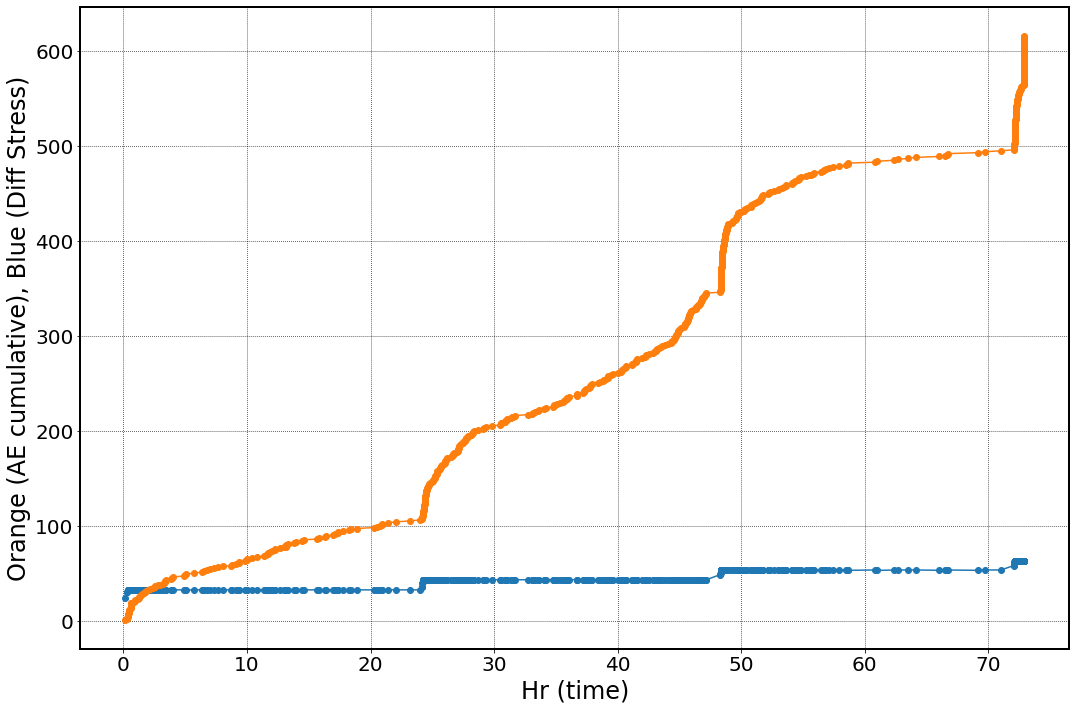

In [14]:
plt.plot(data.time_hr,data.Sig_diff_MPa,'o-')
plt.plot(data.time_hr,np.cumsum(data['count']),'o-')
plt.xlabel('Hr (time)')
plt.ylabel('Orange (AE cumulative), Blue (Diff Stress)')

## Check Synchronization

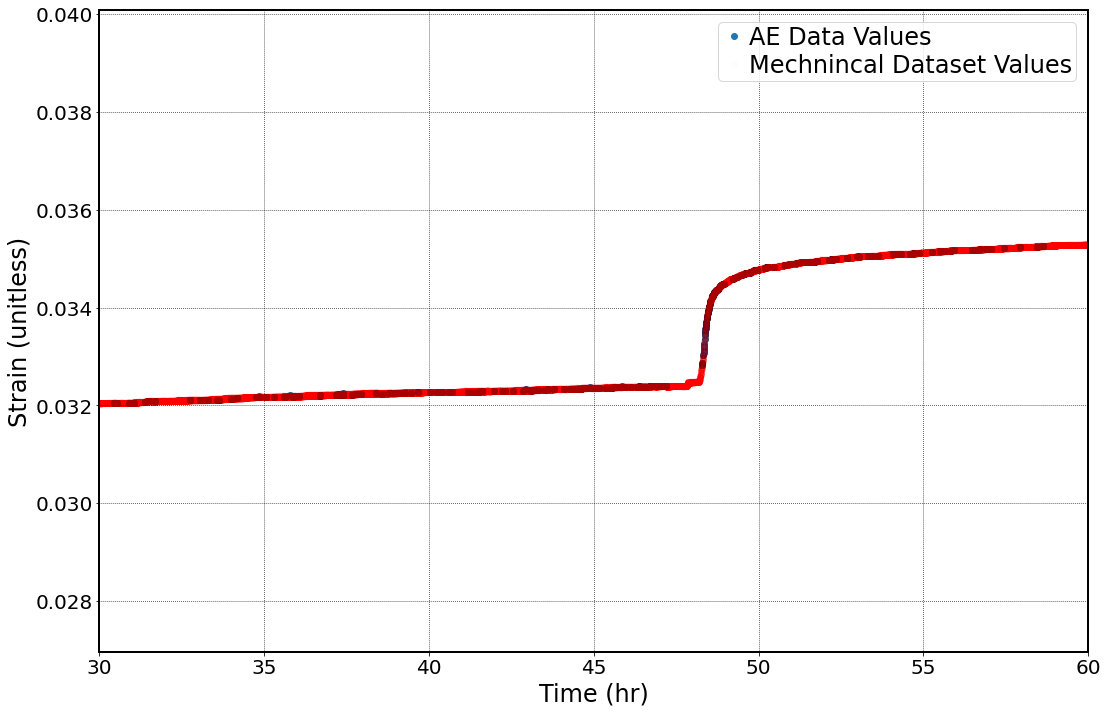

In [15]:
plt.plot(new_data.time_hr,new_data.Strain_ax,'o',label='AE Data Values')
plt.plot(new_data_def.time_hr,new_data_def.Strain_ax,'ro',alpha=0.01,label='Mechnincal Dataset Values') 
plt.xlim([30,60])
plt.xlabel('Time (hr)')
plt.ylabel('Strain (unitless)')
plt.legend()
#plt.ylim([0.,0.01])

Text(0.5, 0, 'Time (Date)')

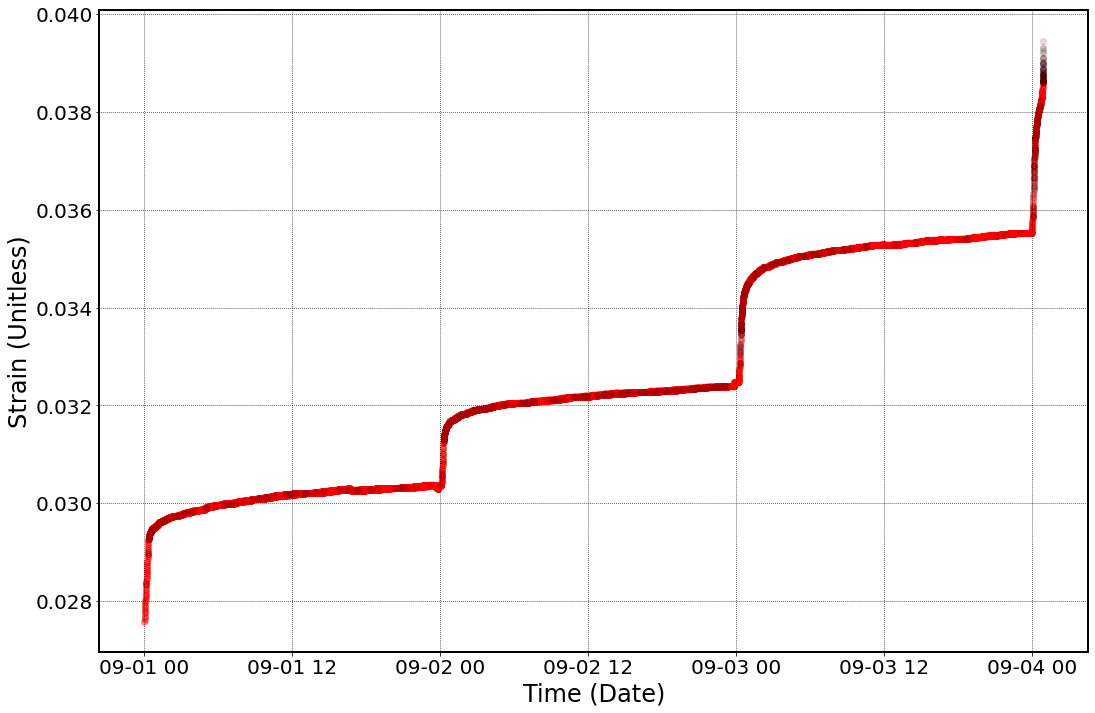

In [16]:
plt.plot(new_data.index,new_data['Strain_ax'],'ko',alpha=.1)
plt.plot(data_def.index,data_def['Strain_ax'],'ro',alpha=0.01)
plt.ylabel('Strain (Unitless)')
plt.xlabel('Time (Date)')
#plt.xlim([np.datetime64('2020-02-19'),np.datetime64('2020-02-20')])
#plt.ylim([0,0.01])
#plt.tight_layout()

### Final Cleaned, Aligned Datasets 

In [17]:
### AE dataset & deformation data with time as the index
# new_data -- AE Data
# new_data_def -- Deformation Data (resampled)

#### Time region cutoff to ensure that both the datasets are comparable

In [18]:
start_date = np.max([new_data_def.index.values[0],new_data.index.values[0]])
end_date = np.min([new_data_def.index.values[-1],new_data.index.values[-1]])
print(f'{start_date}, {end_date}')

2021-09-01T00:09:16.000000000, 2021-09-04T00:54:00.000000000


## Analysis Parts :

a) Make a catalog for the AE data with strain rate etc (extended mechanical catalog)

b) Data plotting with different time aggregations & saving time series for analysis

### Make a time aggregated dataset (mechanical data) to merge with the event catalog

In [36]:
time_window = 60  ## Aggregation Time Window in seconds

In [37]:
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
new_AE_data = pd.merge_asof(new_data, new_data_def_Sampl, left_index = True, right_index = True,
                            direction='forward',tolerance=pd.Timedelta(seconds=time_window),
             suffixes =['','_1min'])
## Note that when we aggregate, the time label is assigned to the end of the time window (right). So, for an event,
#  the relevant data is in the next timestamp (or not relevant - so we have a tolerance) ..

In [38]:
new_AE_data.columns

Index(['index', 'Unnamed: 0', 'timestamp', 'evID', 'Disp_mm', 'Sig_diff_MPa',
       'Strain_ax', 'time_hr', 'count', 'Disp_mm_1min', 'Sig_diff_MPa_1min',
       't_def', 'Strain_ax_1min', 'time_hr_1min', 'Time_Since_Step_1',
       'Time_Since_Step_2', 'Time_Since_Step_3', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')

In [27]:
new_AE_data.to_csv(path_AE_data.split('.csv')[0]+'_AppendedMechanical_'+time_agg+'.csv')

In [23]:
del new_AE_data

In [39]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)

%matplotlib qt
plt.plot(new_AE_data['time_hr'],new_AE_data['Sig_diff_MPa'],'o')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Sig_diff_MPa'],'k-',alpha=0.2)
plt.plot(new_AE_data['time_hr'],new_AE_data['Strain_ax']*3000,'ro')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Strain_ax']*3000,'r-',alpha=0.2)
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['AE_rate_count']*3,'b-')

Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')


## Plotting/Analysis of the data with AE rate etc 

In [23]:
try  :
    os.mkdir(path_to_save_out_time_series+name_exp)
except :
    print(f' {path_to_save_out_time_series+name_exp} Exists')
    
try  :
    os.mkdir(path_to_save_out_time_series+name_exp+'/'+time_agg)
except :
    print(f"{path_to_save_out_time_series+name_exp+'/'+time_agg} Exists")

path_save_file = path_to_save_out_time_series+name_exp+'/'+time_agg

 /home/tmittal/Causality/Basalt_Data/dataforcausalitytests_CO2_Wet_Basalt Exists
/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_CO2_Wet_Basalt/1min Exists


In [30]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   

Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/CO2_Wet_Basalt Exists
Index value for the stress steps:  [   1   11 1446 2893 4319]
Time(hr) for the stress steps:  [ 0.17458333 24.25791667 48.37458333 72.14125   ]


35

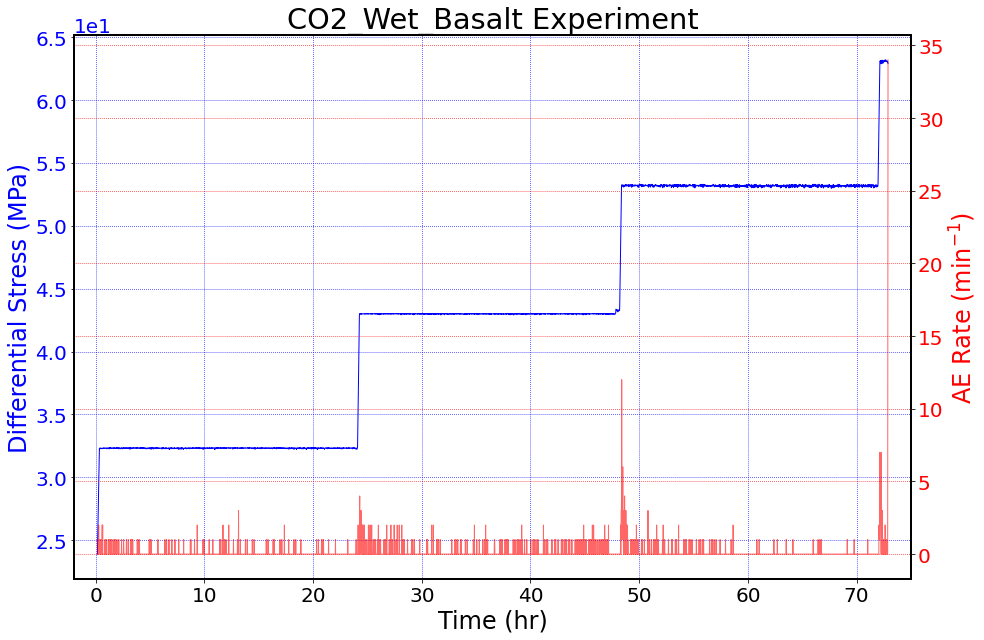

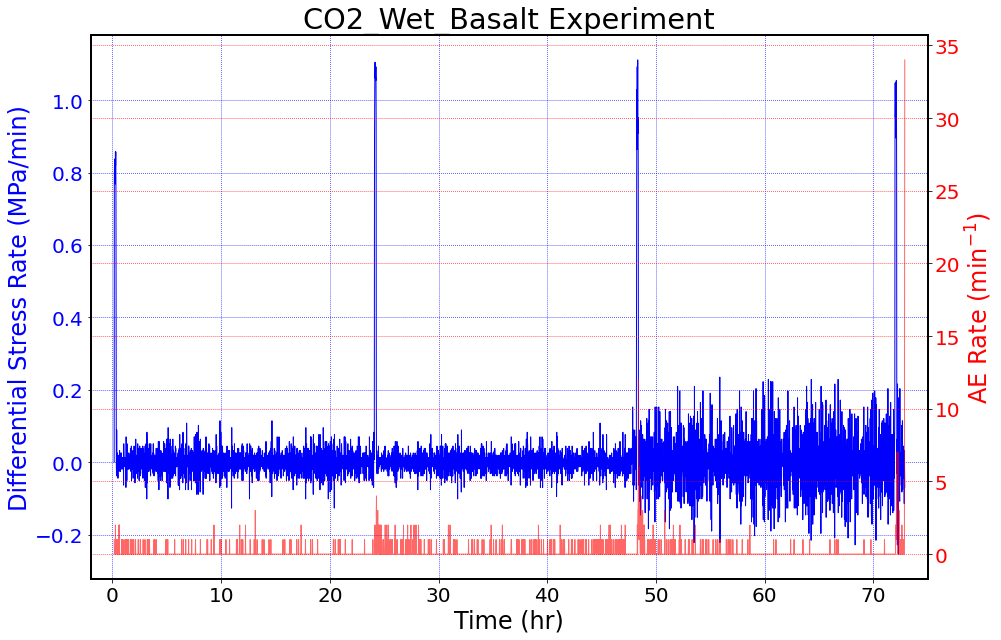

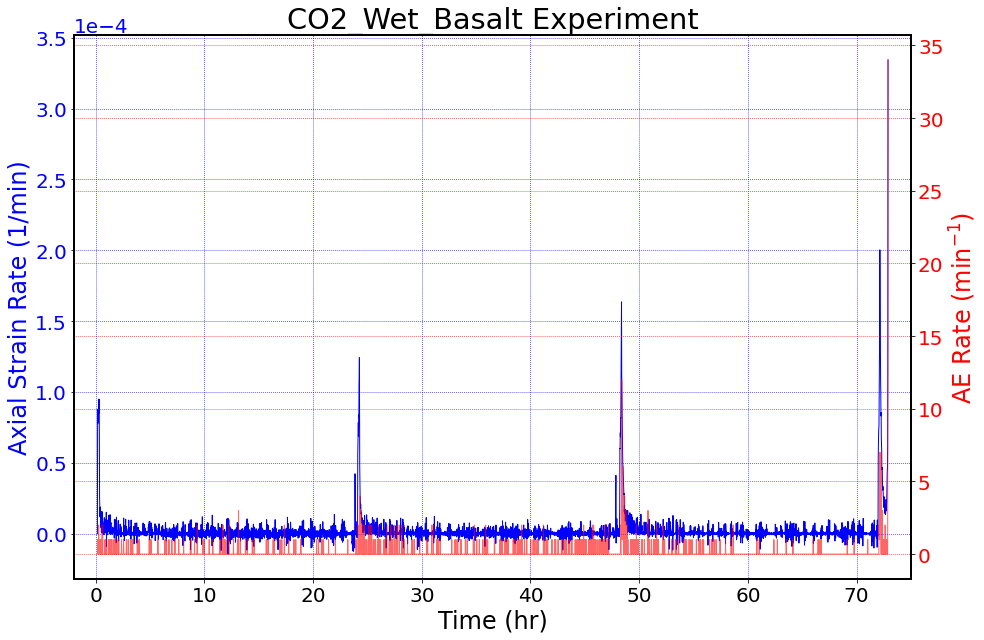

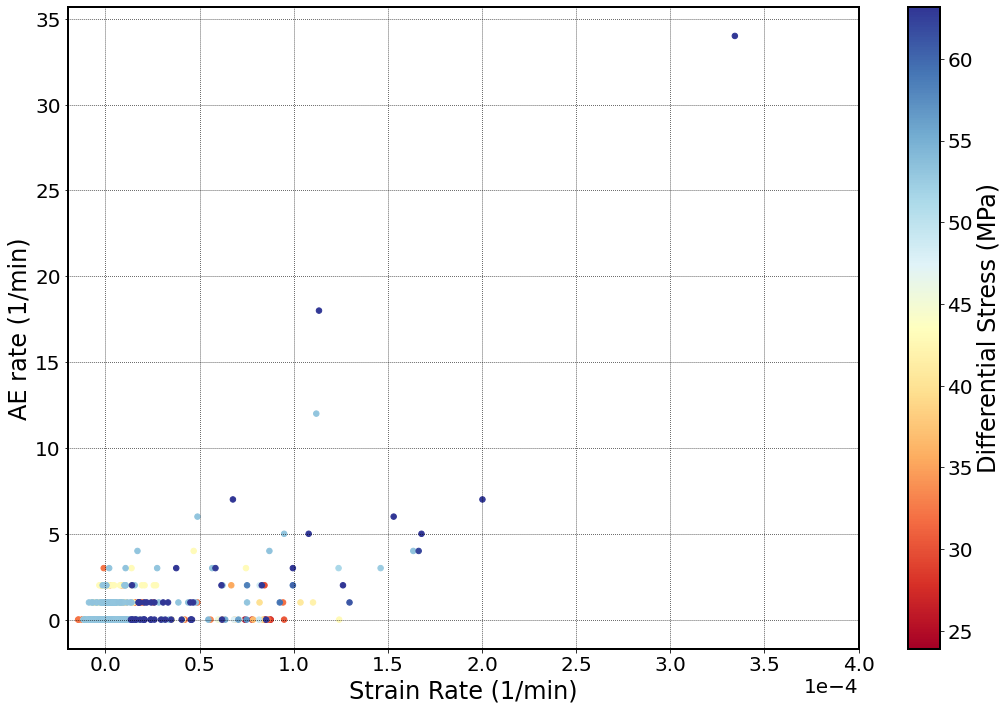

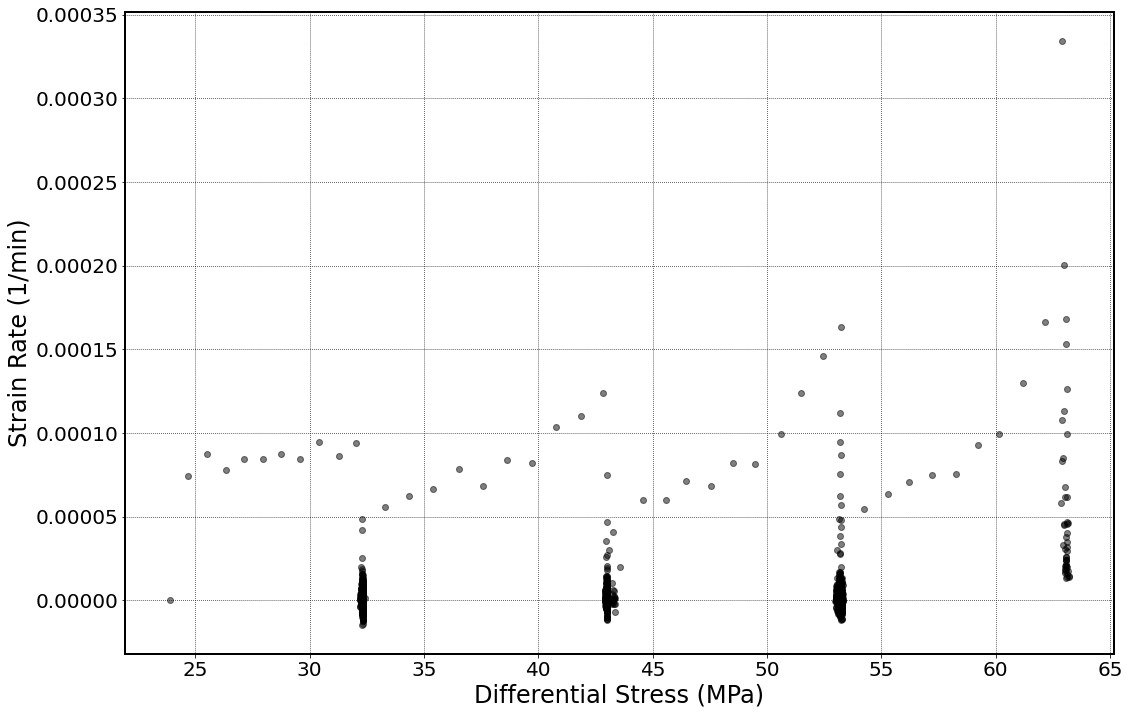

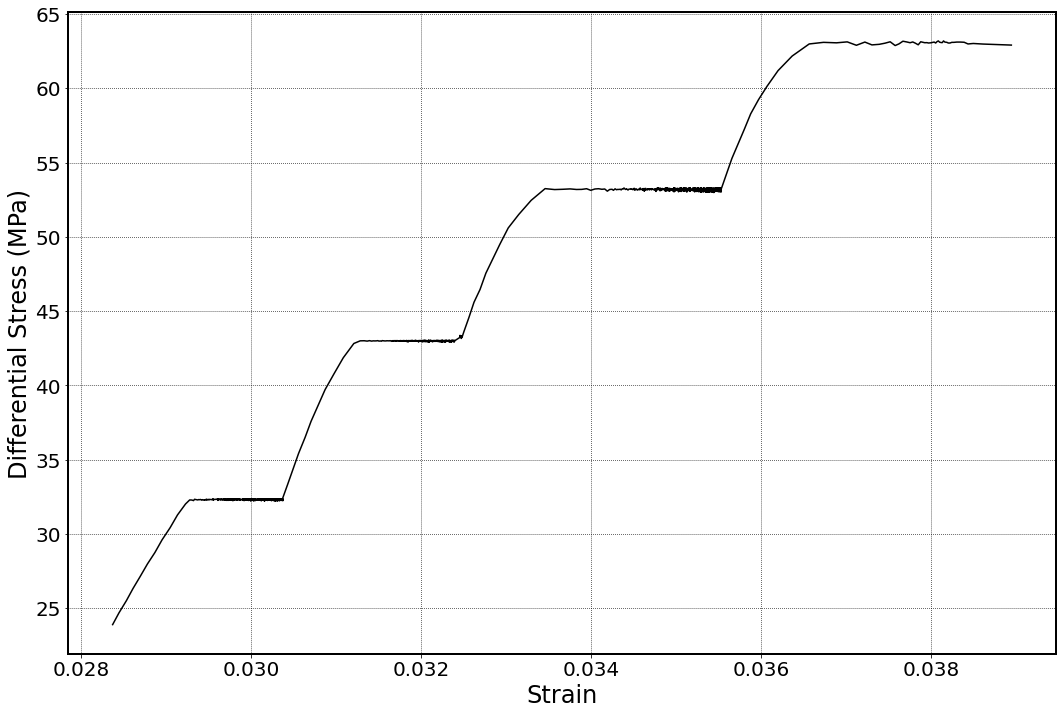

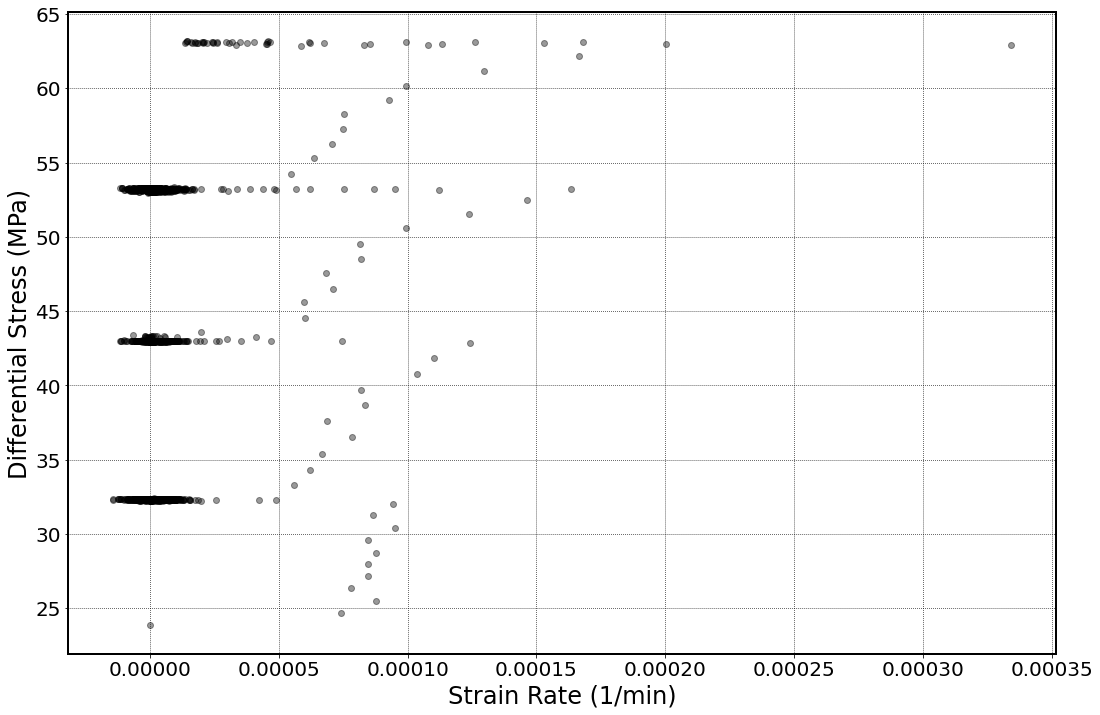

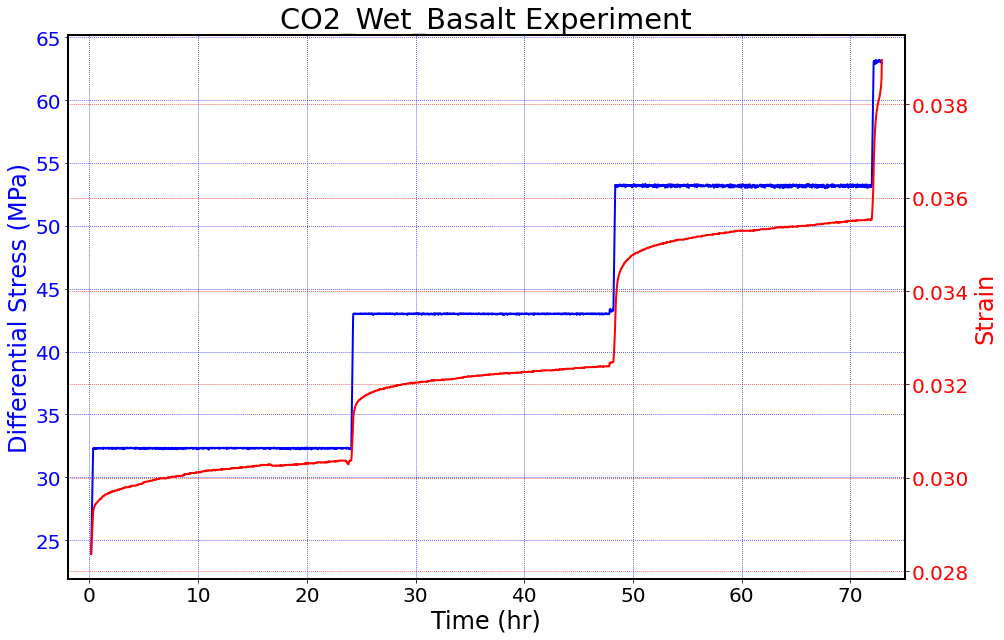

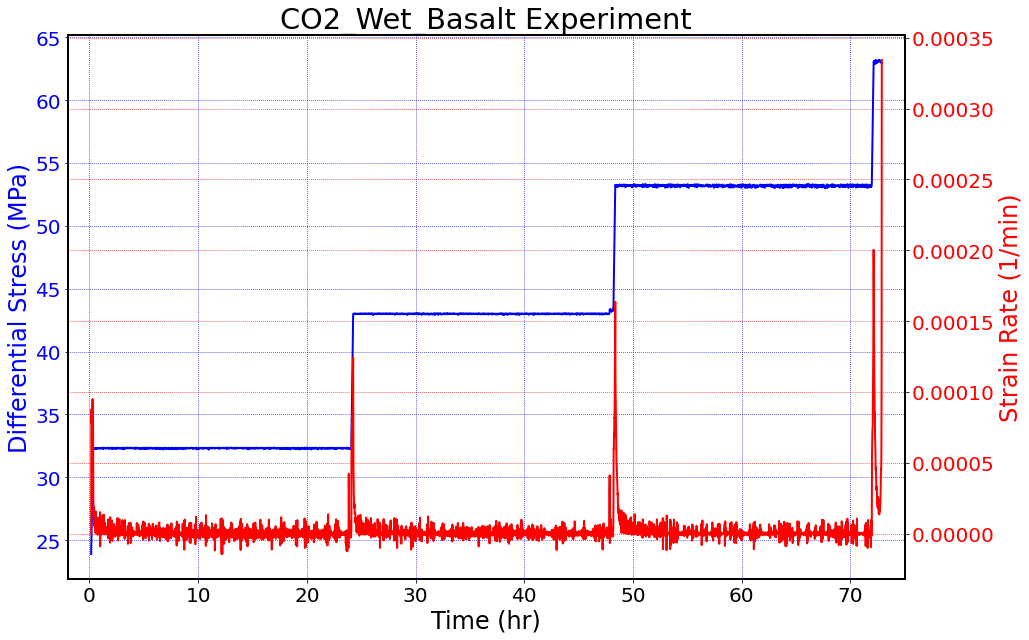

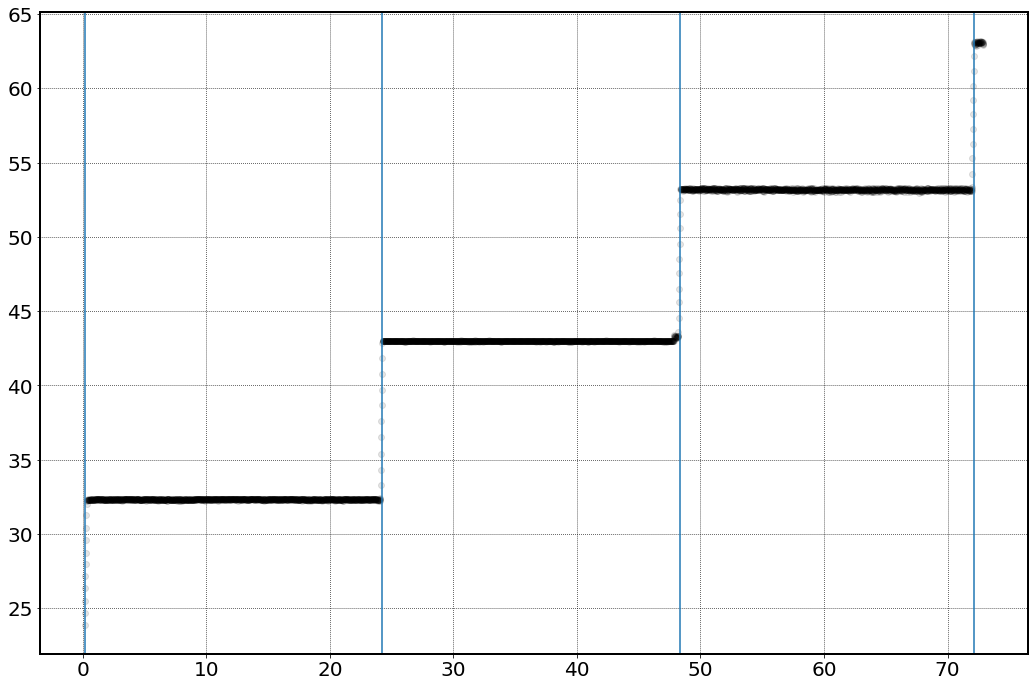

In [24]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,max_val=75,Temperature=False)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/CO2_Wet_Basalt Exists
Index value for the stress steps:  [   1    6  724 1447 2160]
Time(hr) for the stress steps:  [ 0.18291667 24.28291667 48.38291667 72.14958333]


47342

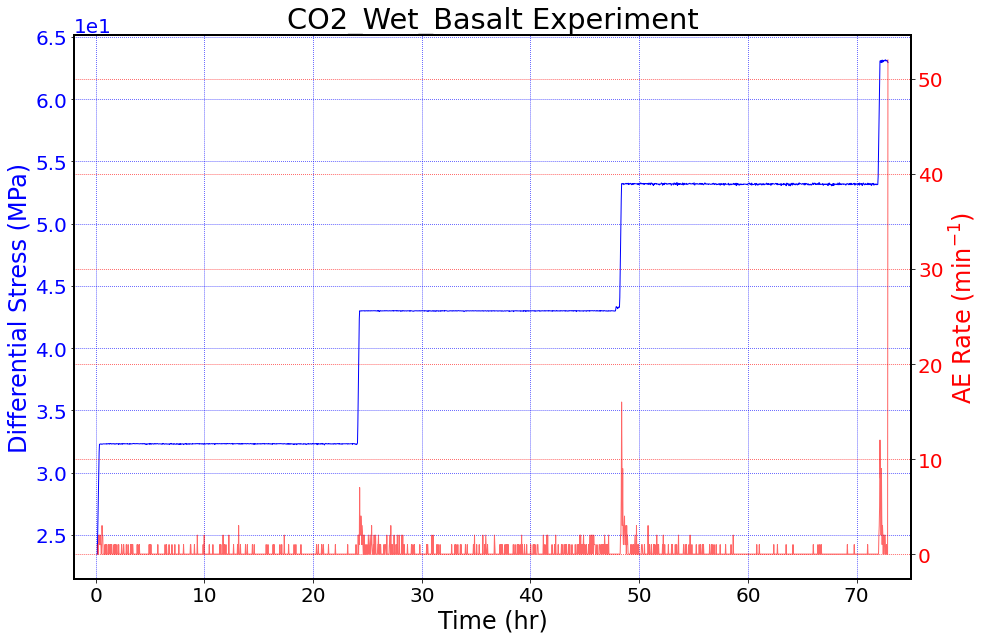

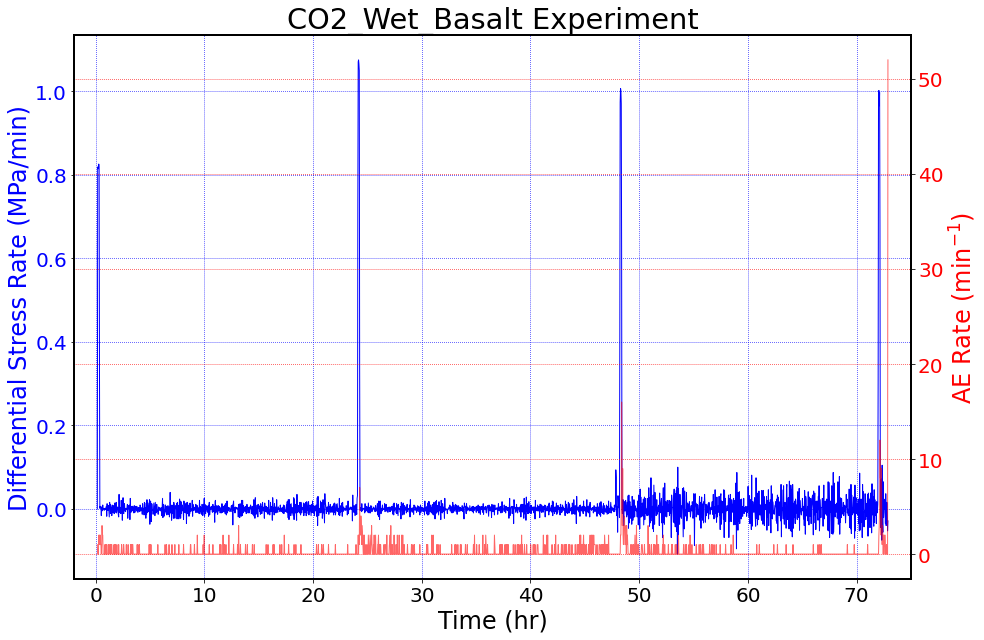

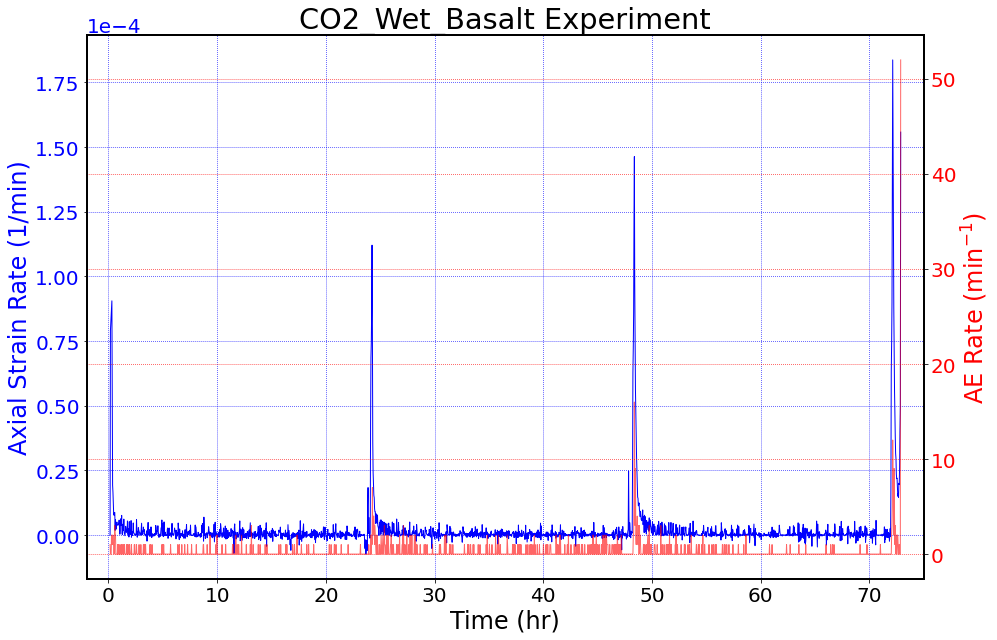

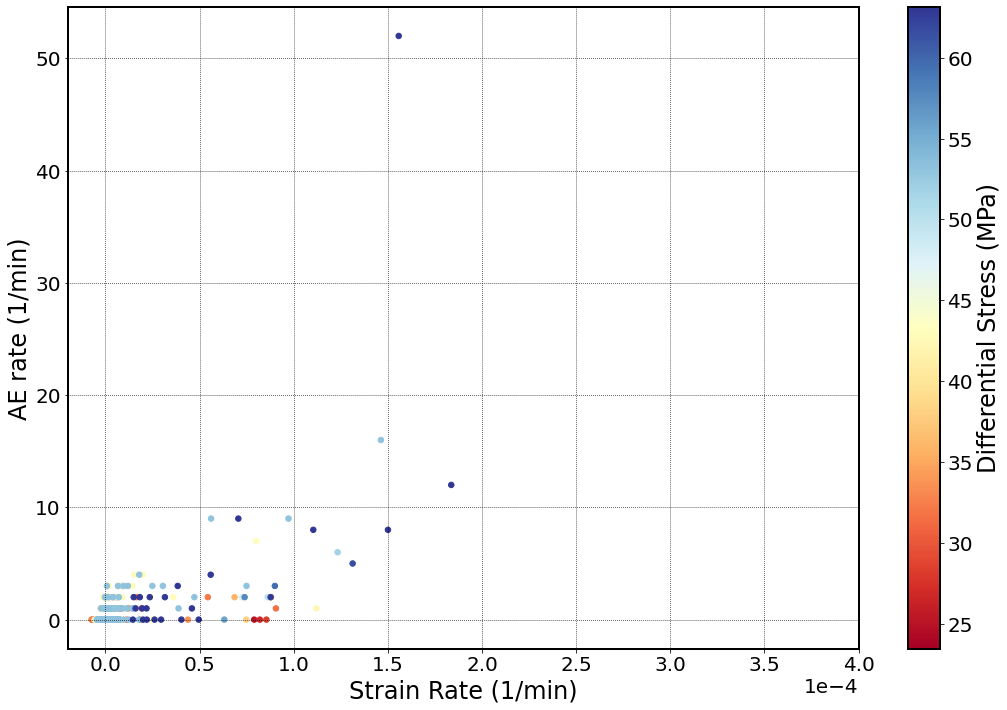

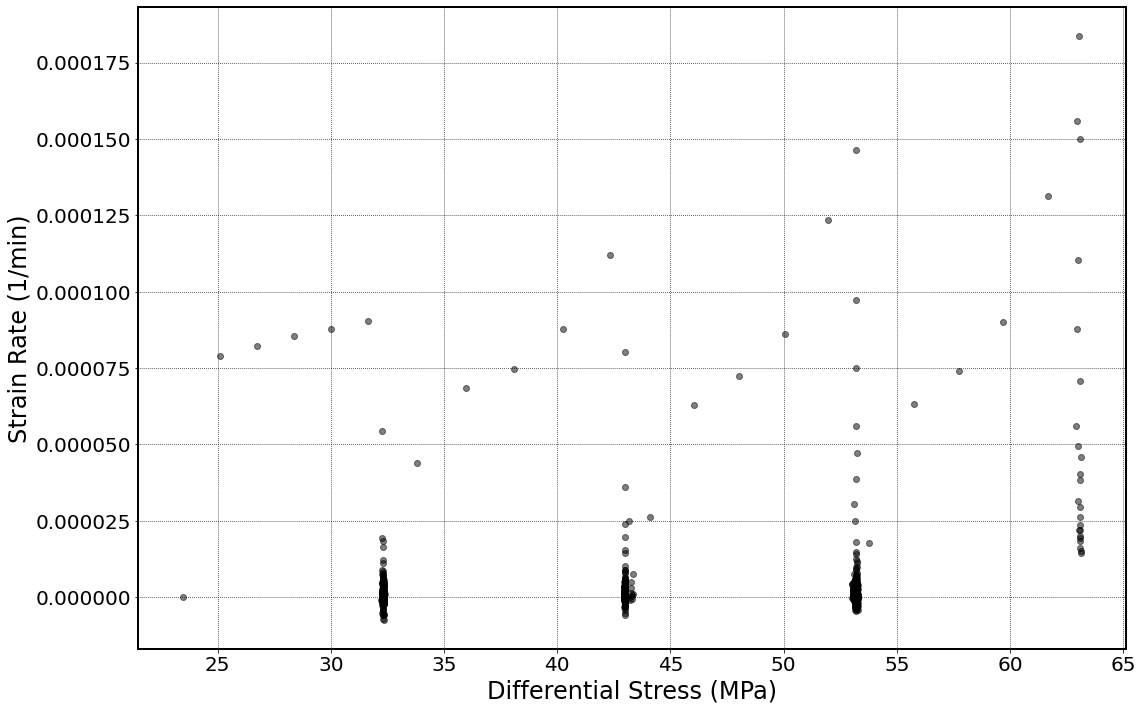

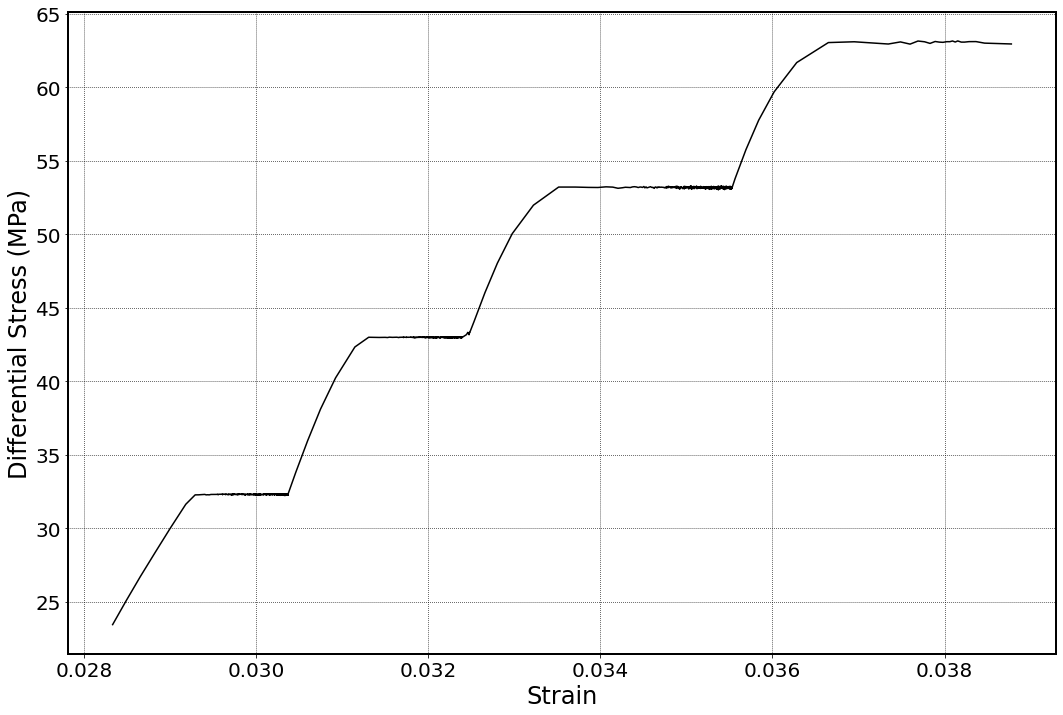

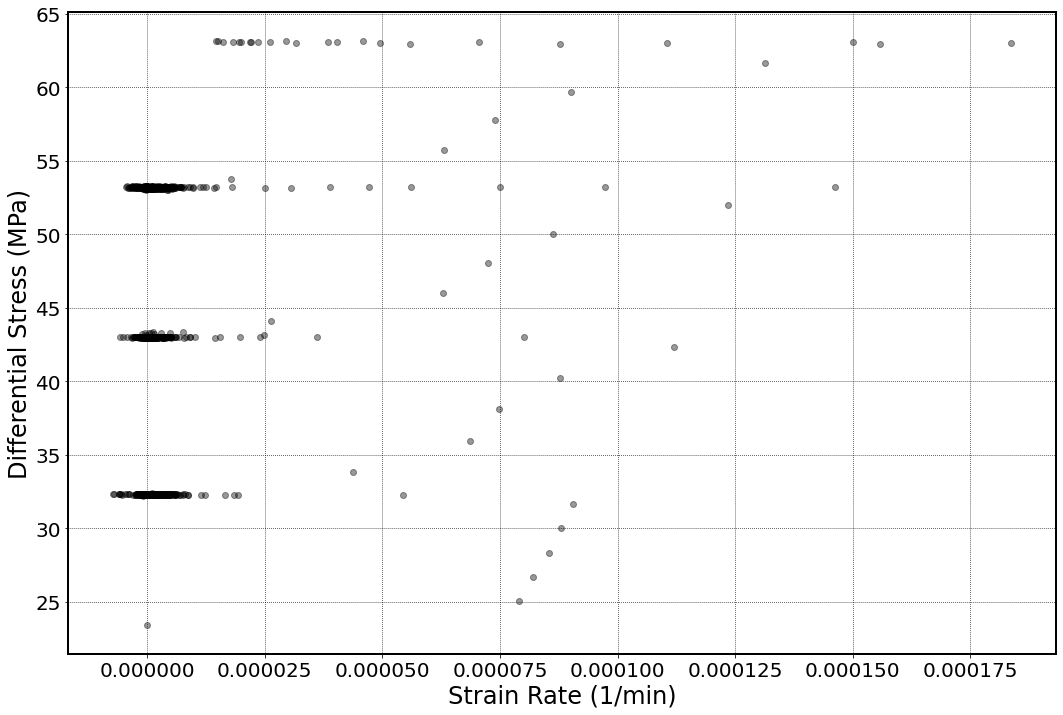

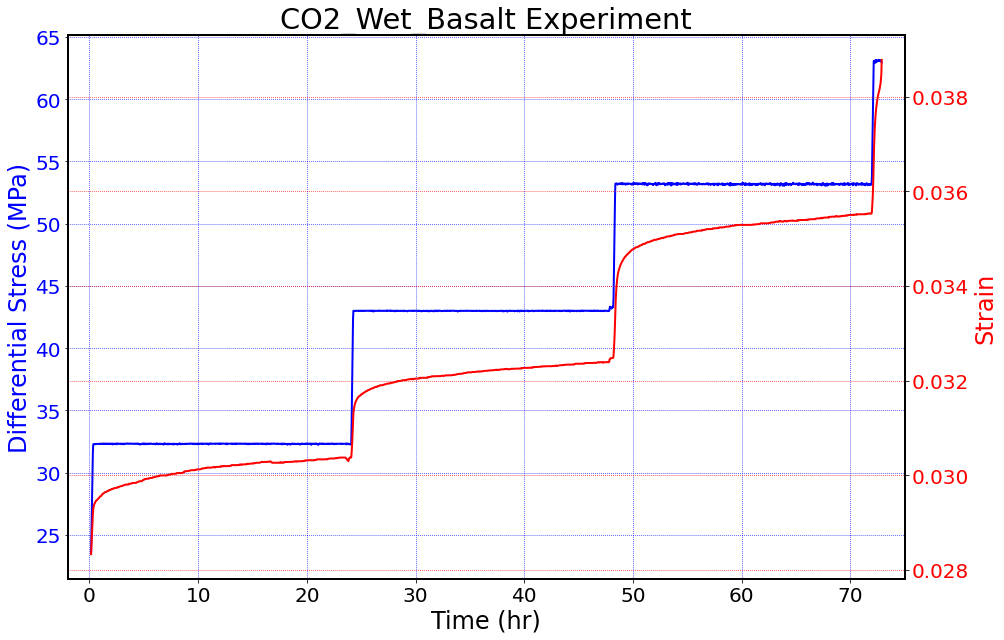

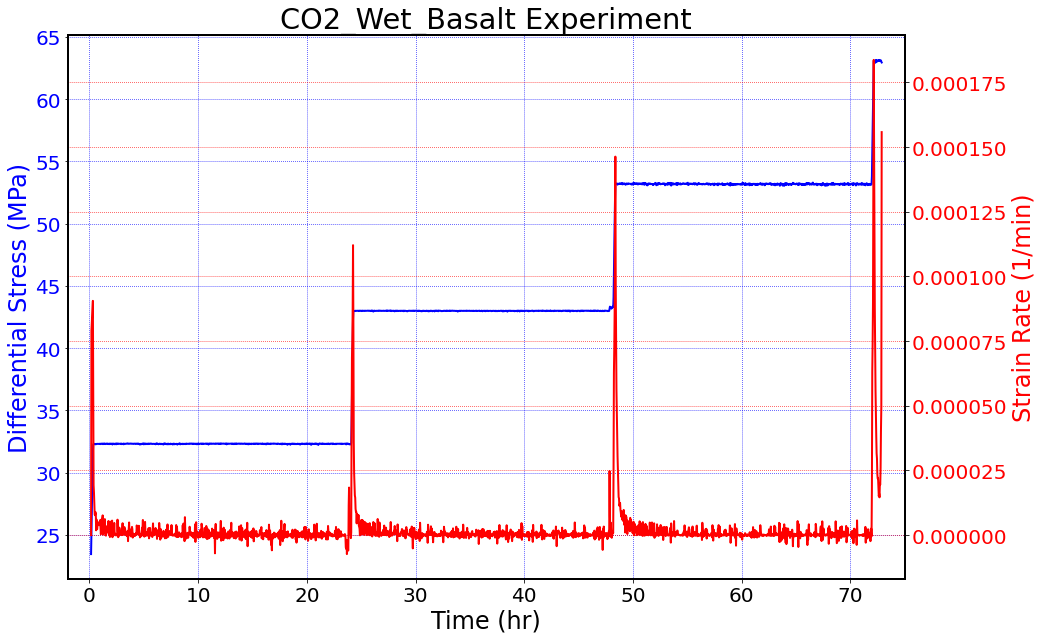

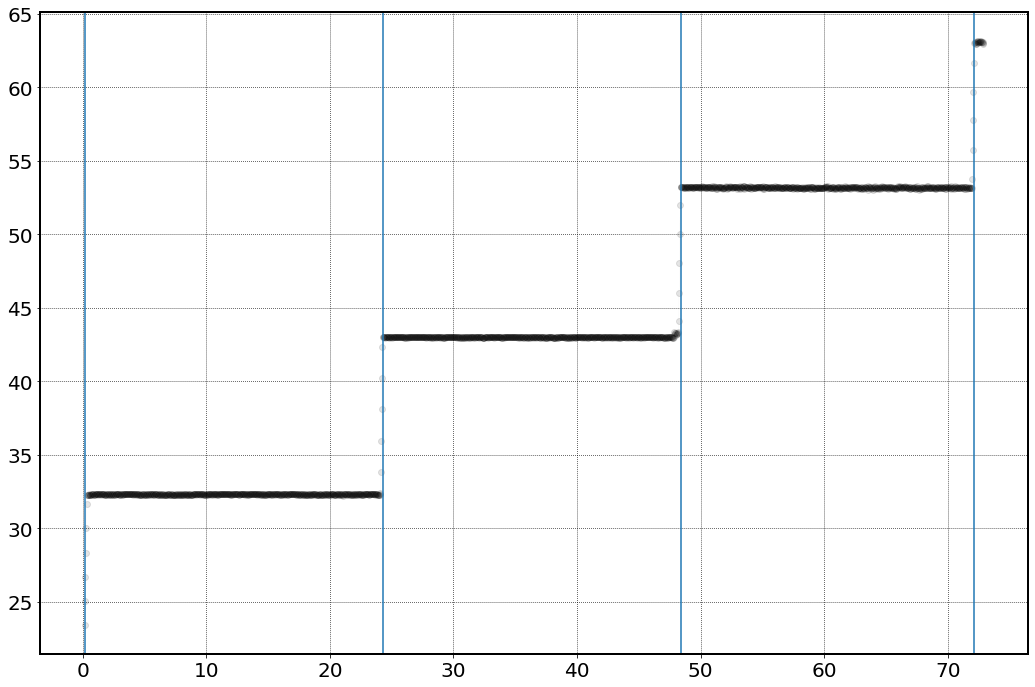

In [25]:
time_window = 120
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,max_val=75,Temperature=False)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/CO2_Wet_Basalt Exists
Index value for the stress steps:  [   1    3  482  964 1440]
Time(hr) for the stress steps:  [ 0.22458333 24.27458333 48.37458333 72.17458333]


46694

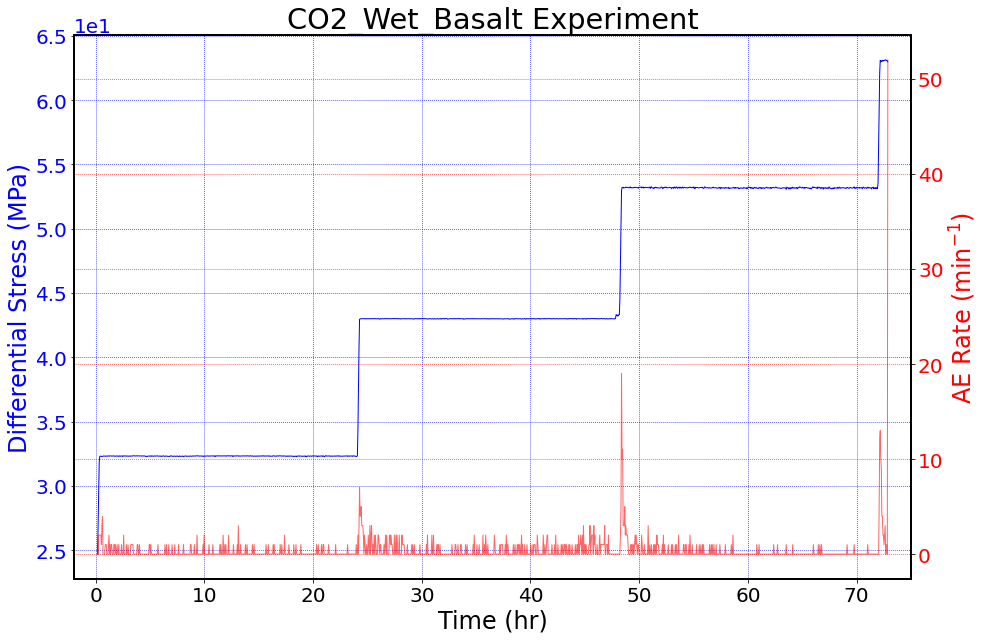

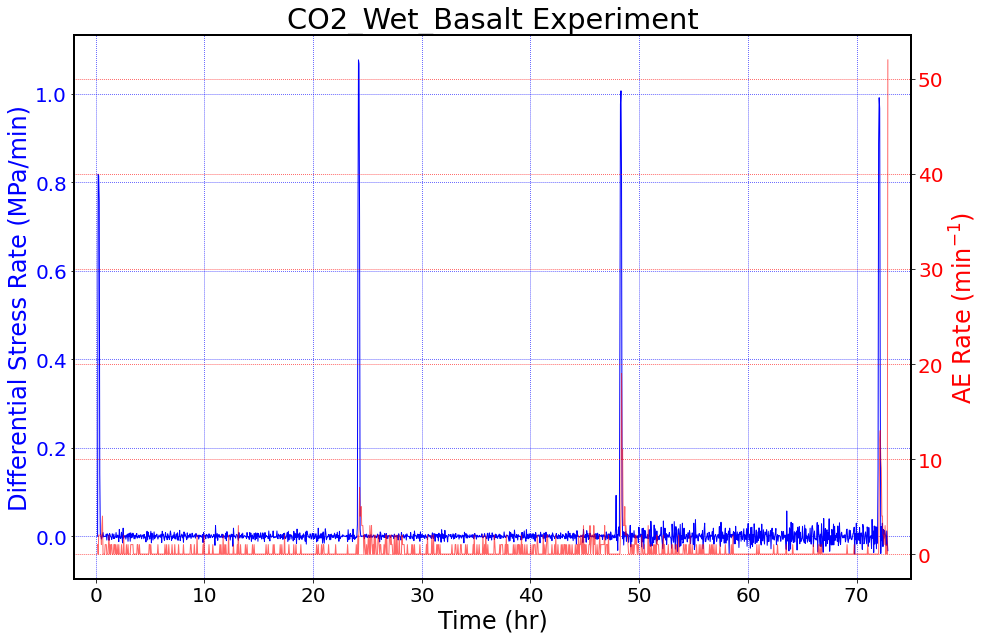

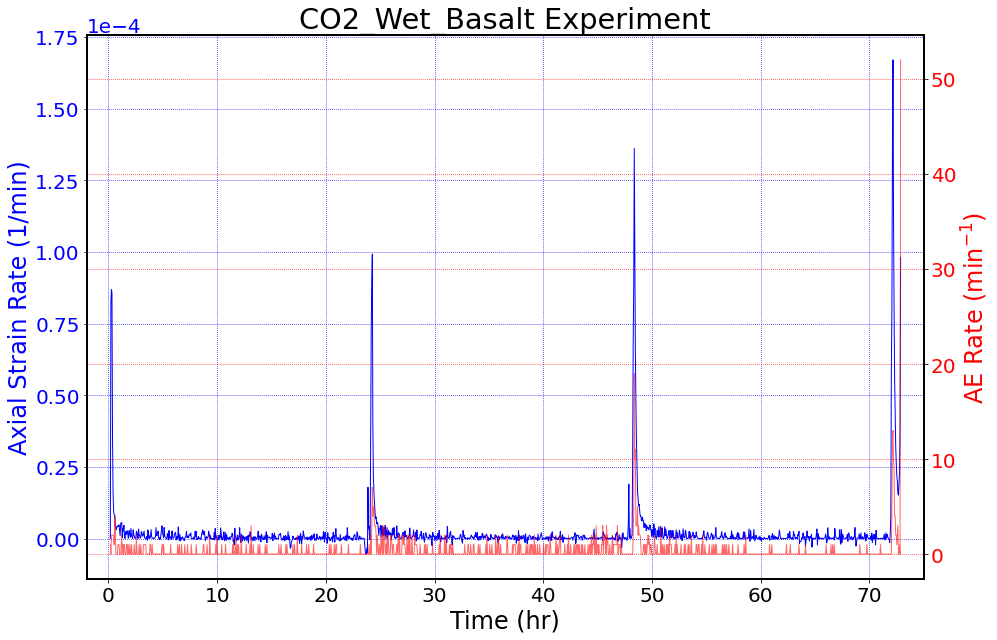

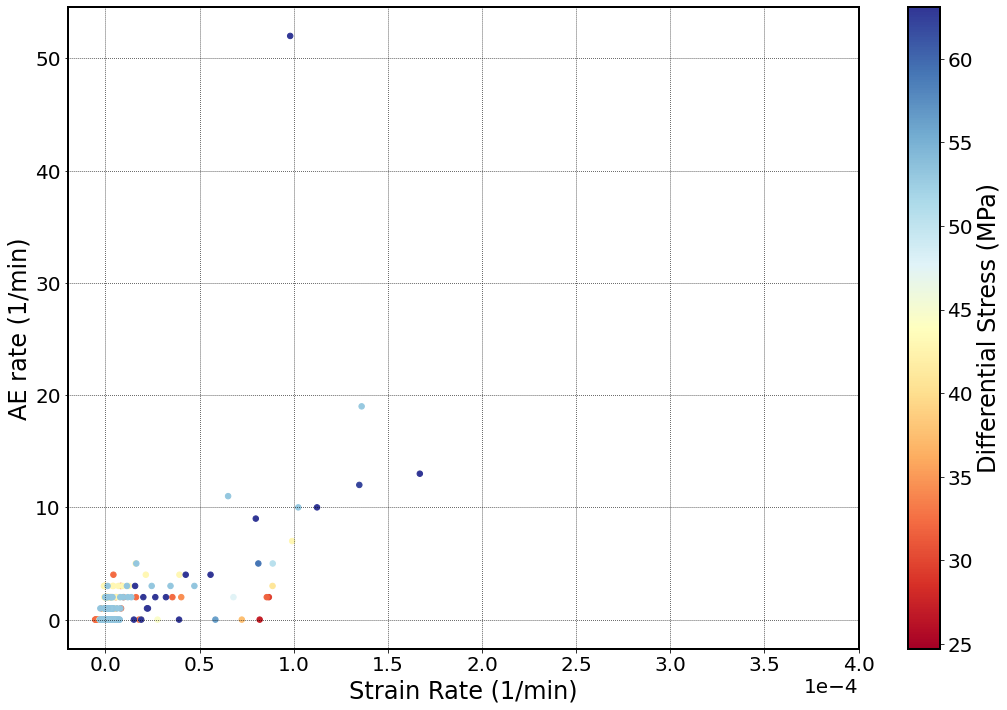

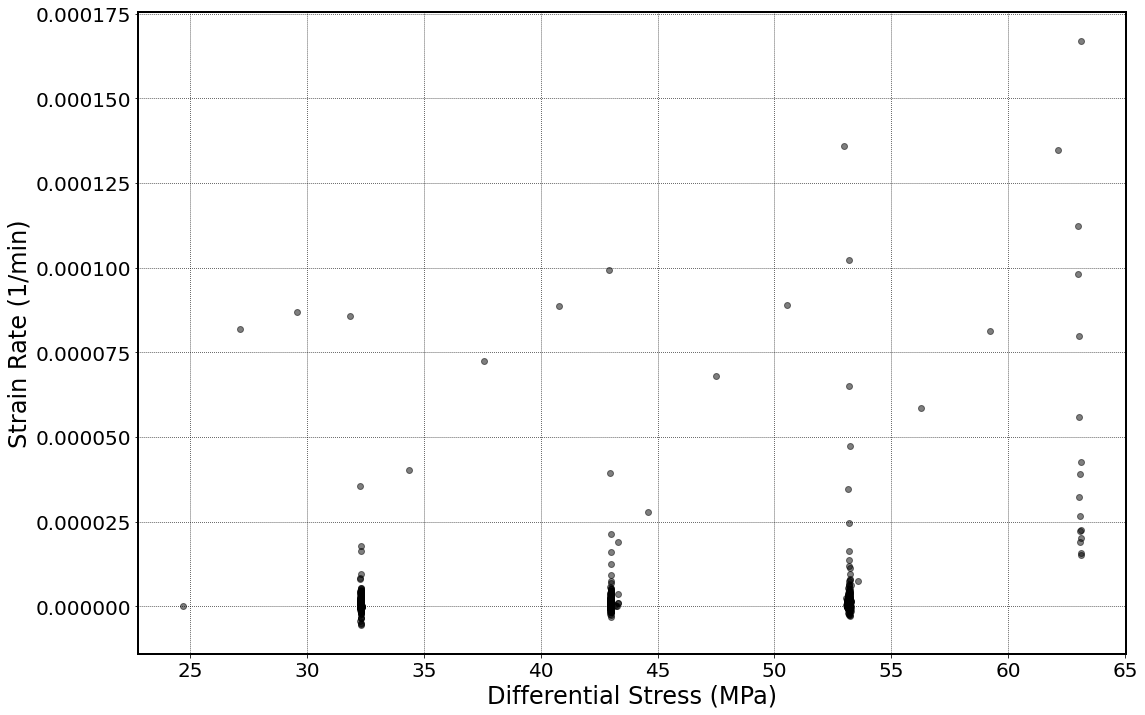

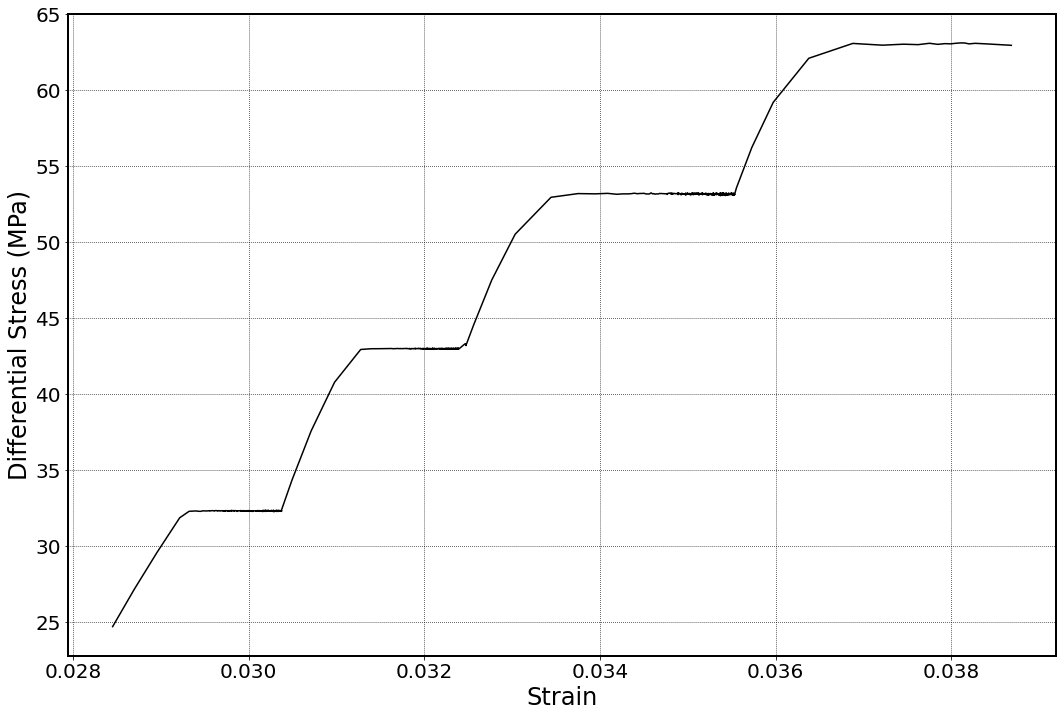

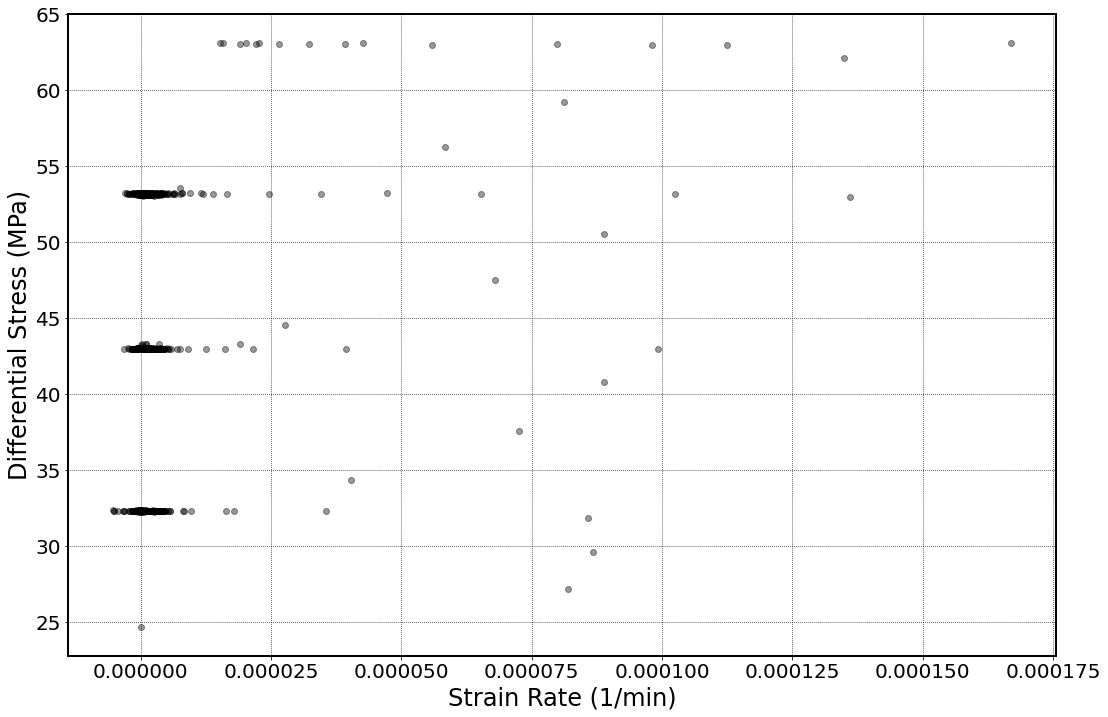

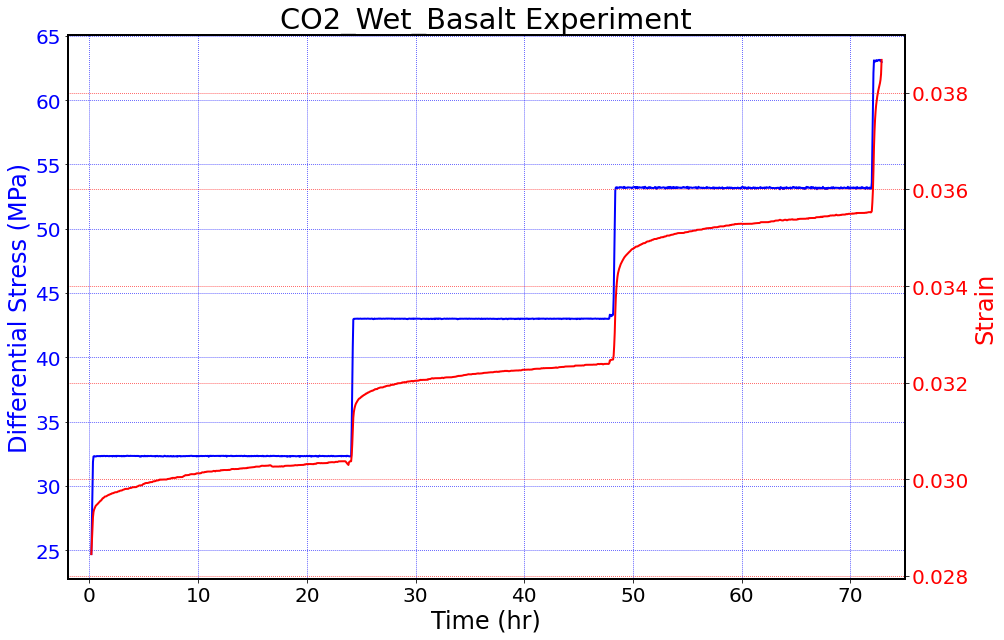

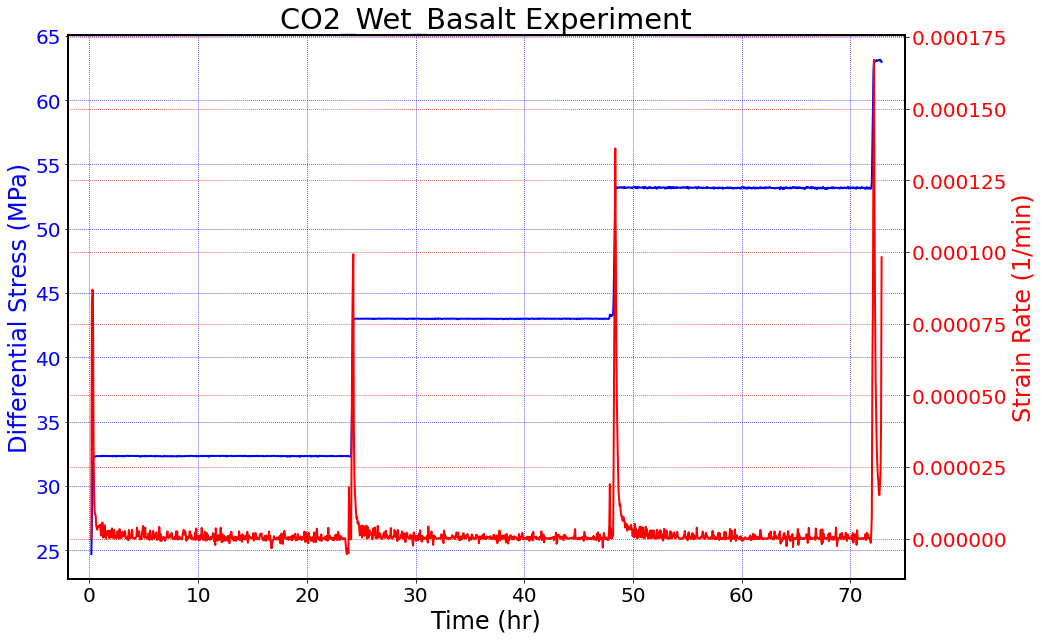

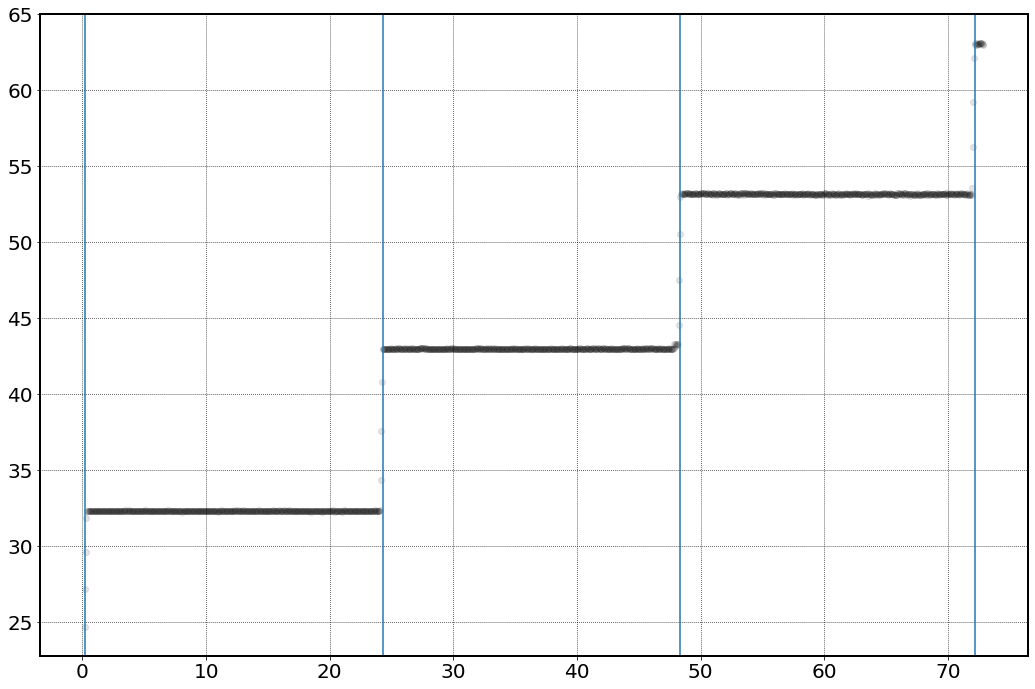

In [26]:
time_window = 180
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,max_val=75,Temperature=False)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/CO2_Wet_Basalt Exists
Index value for the stress steps:  [  1   3 290 579 864]
Time(hr) for the stress steps:  [ 0.20791667 24.29125    48.37458333 72.12458333]


46709

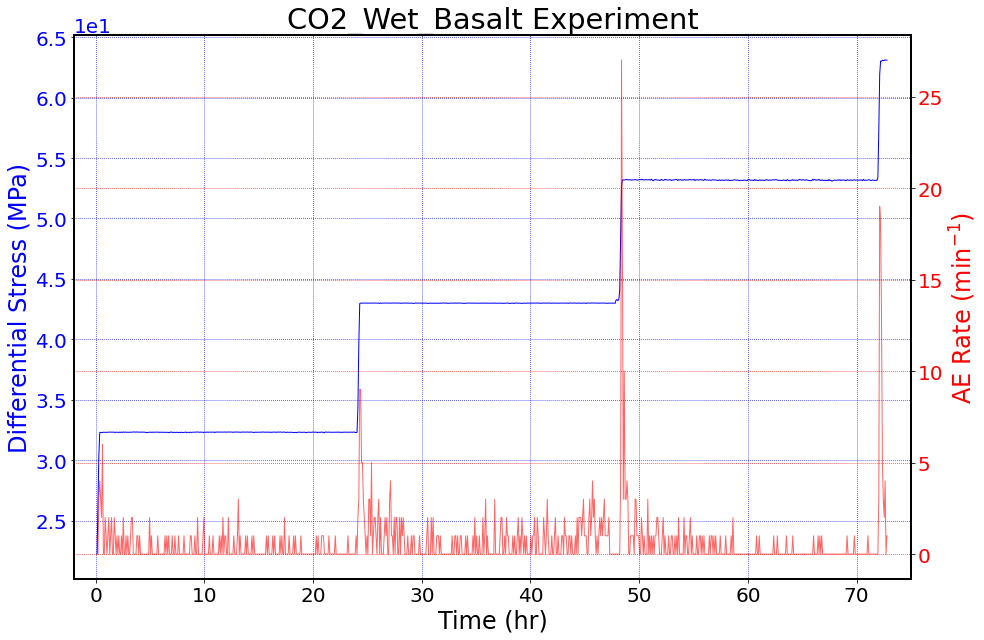

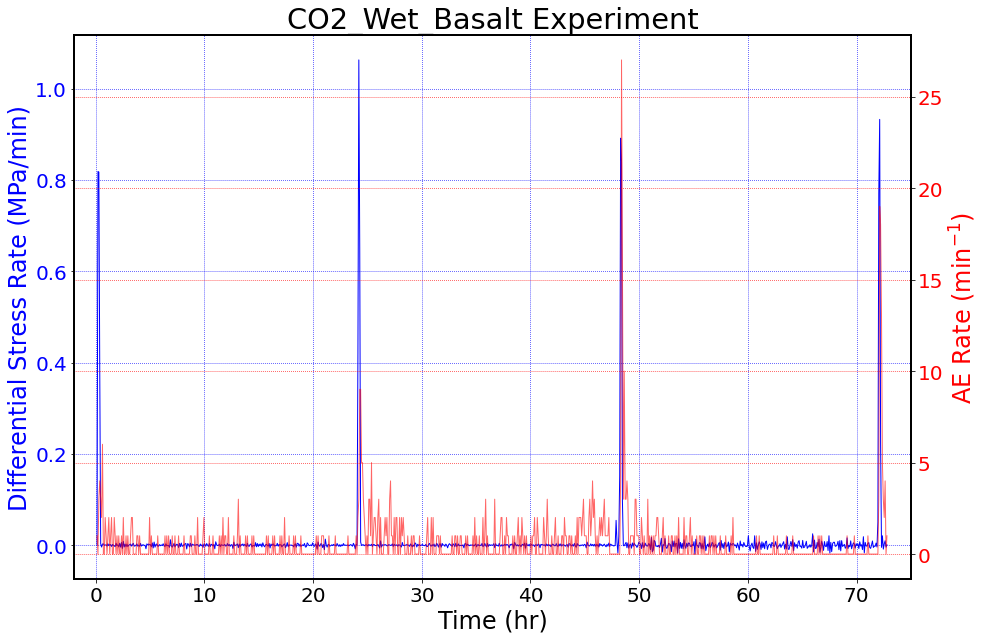

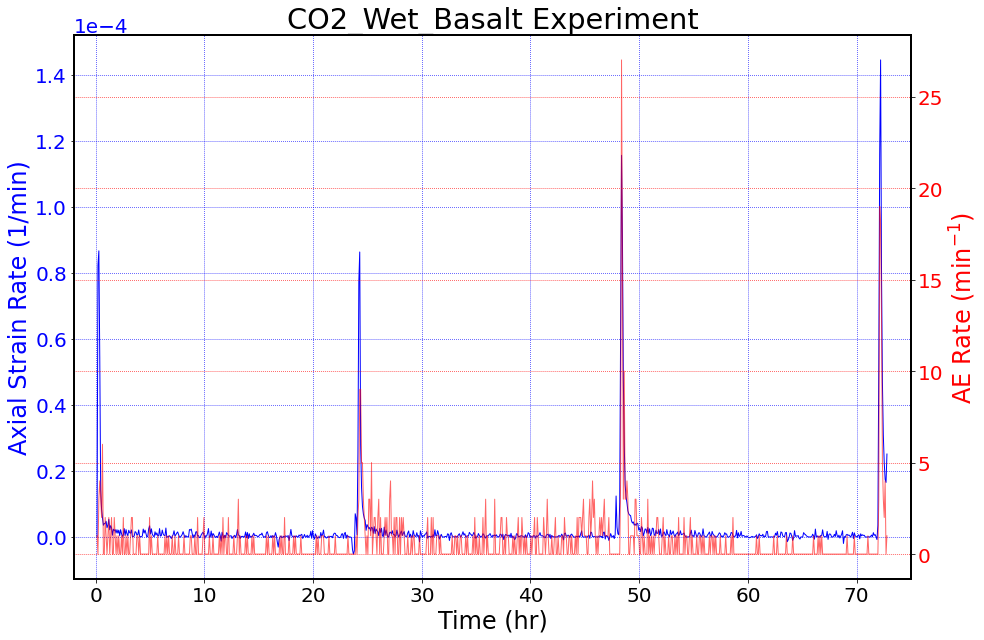

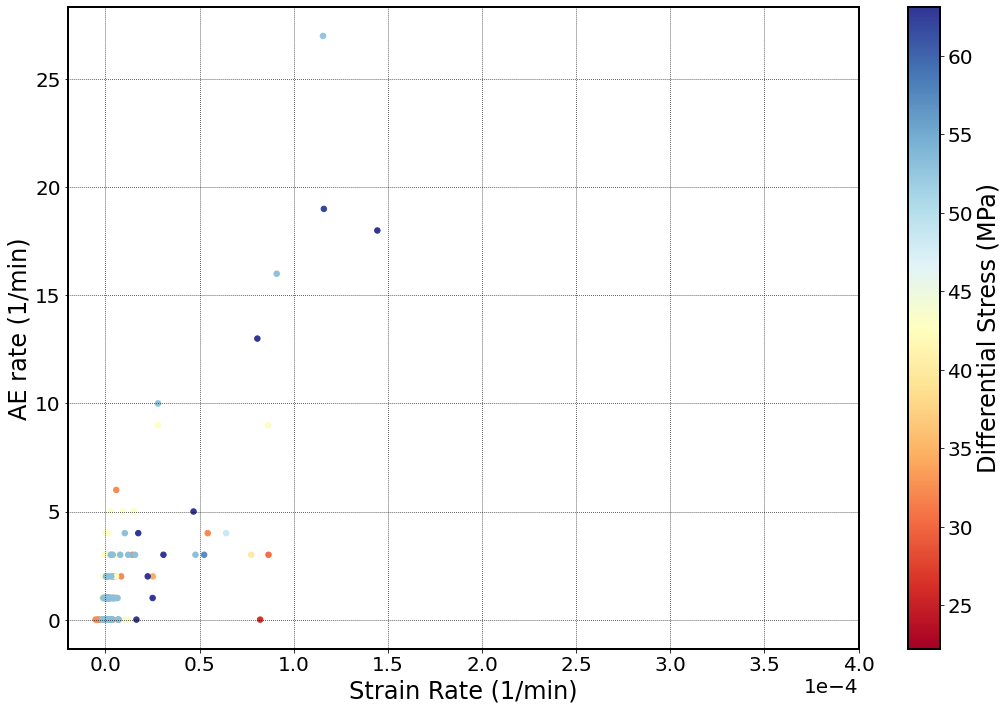

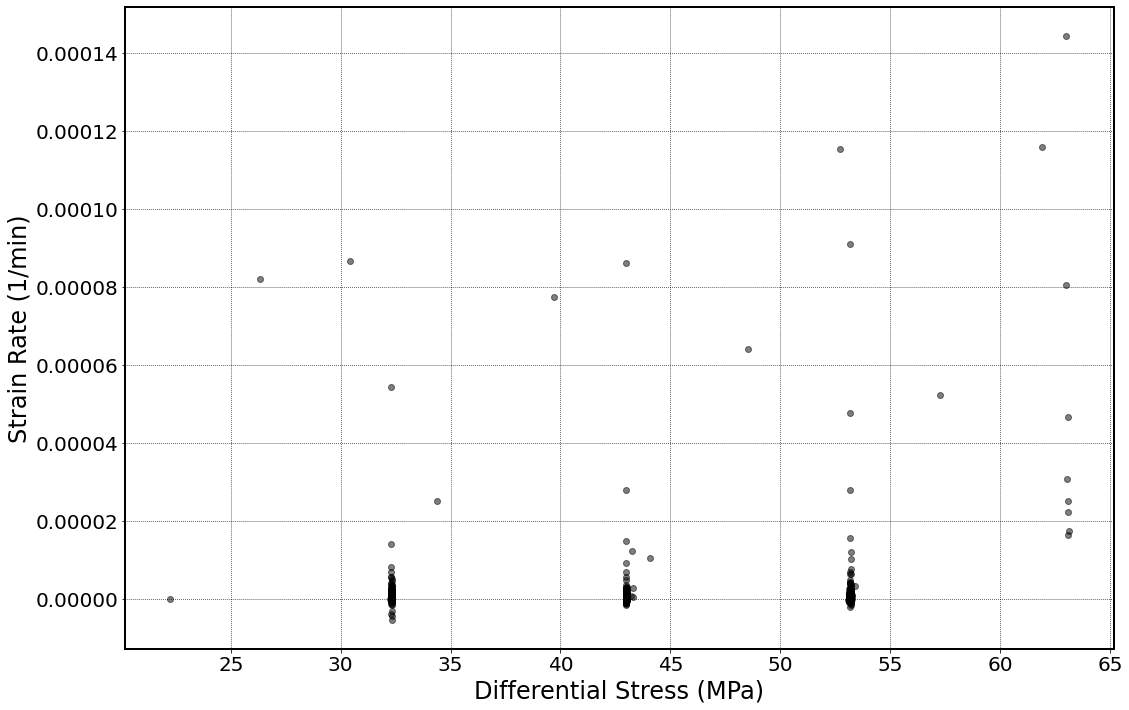

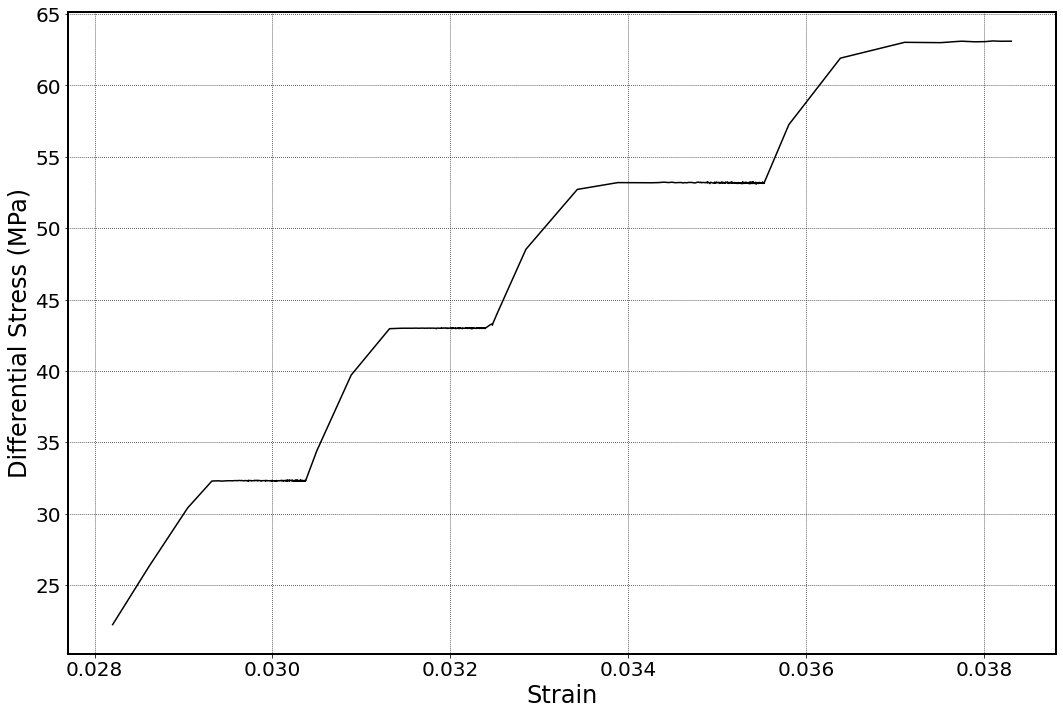

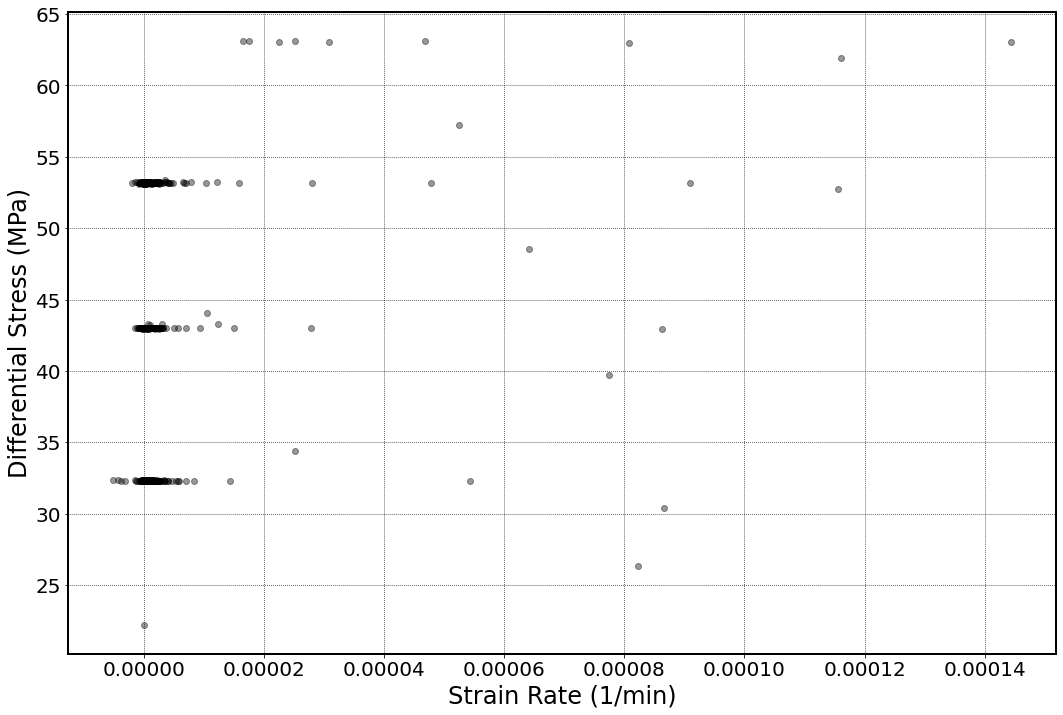

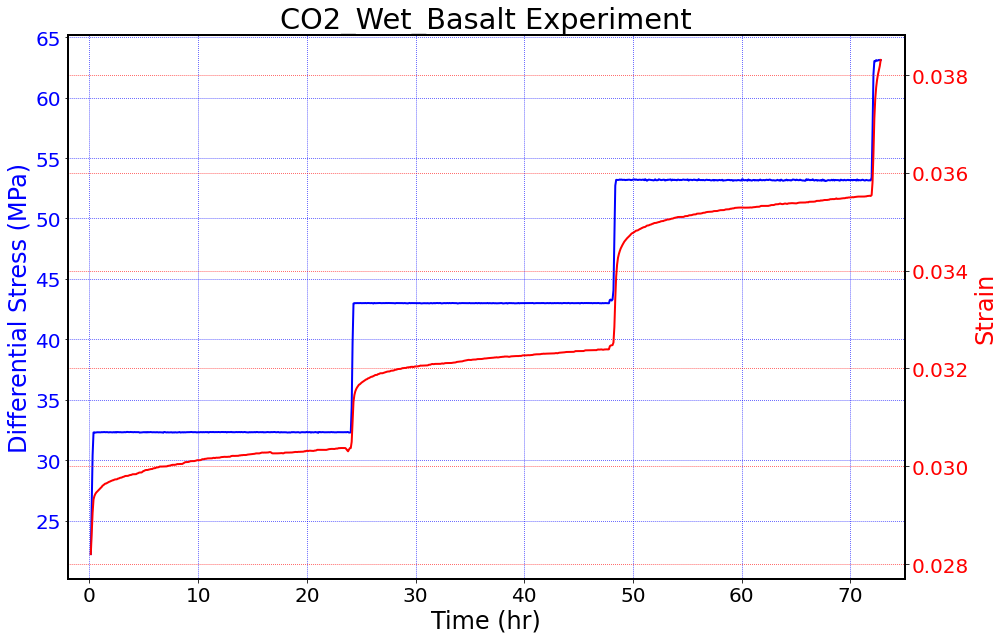

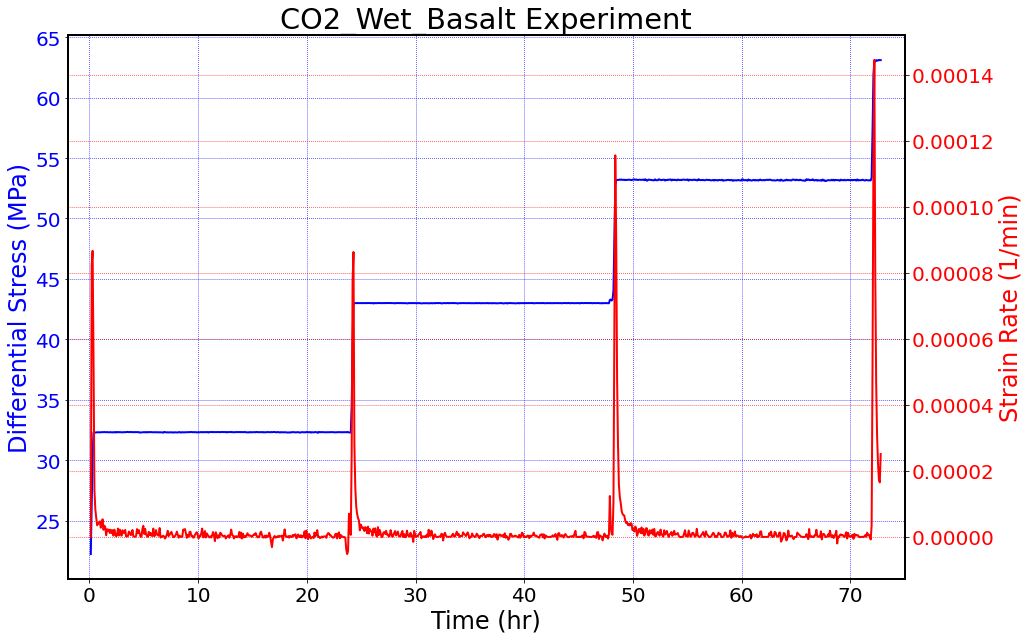

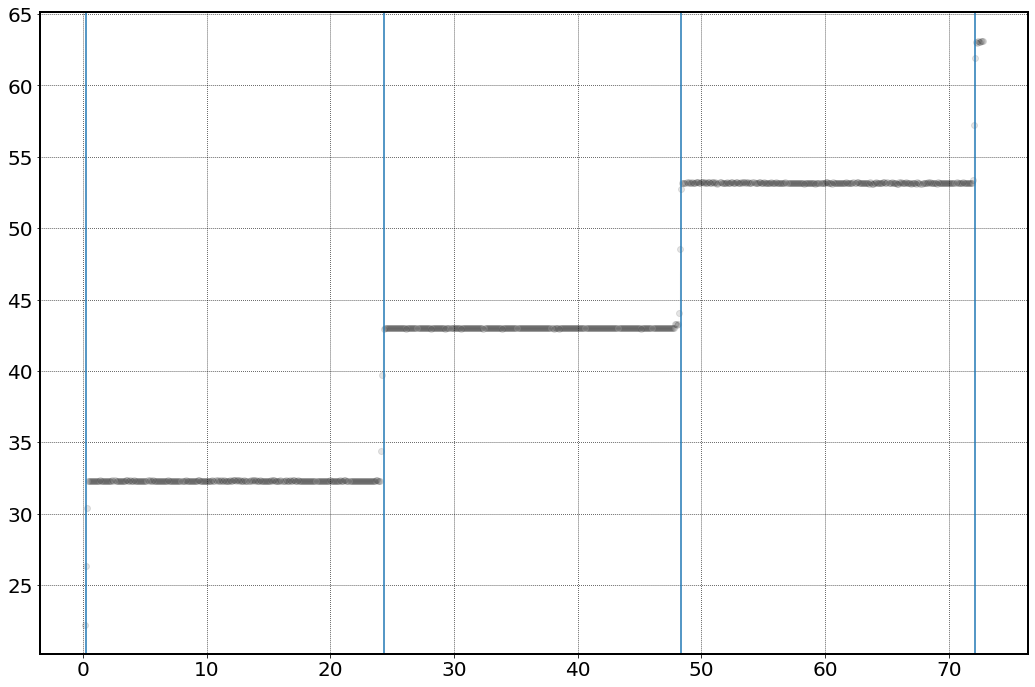

In [27]:
time_window = 300
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,max_val=75,Temperature=False)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/CO2_Wet_Basalt Exists
Index value for the stress steps:  [  1   2 145 290 433]
Time(hr) for the stress steps:  [ 0.24958333 24.24958333 48.41625    72.24958333]


47335

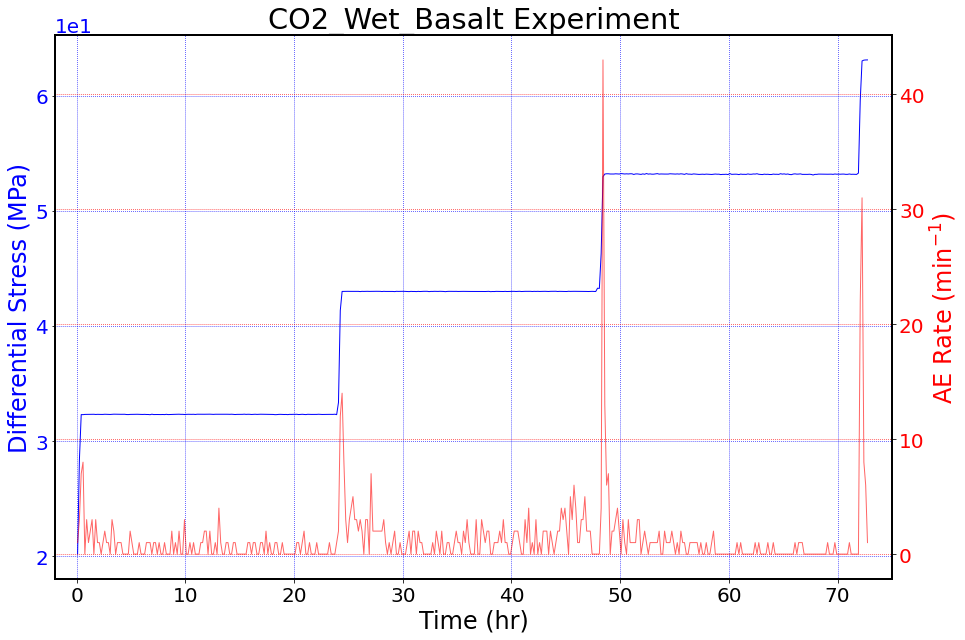

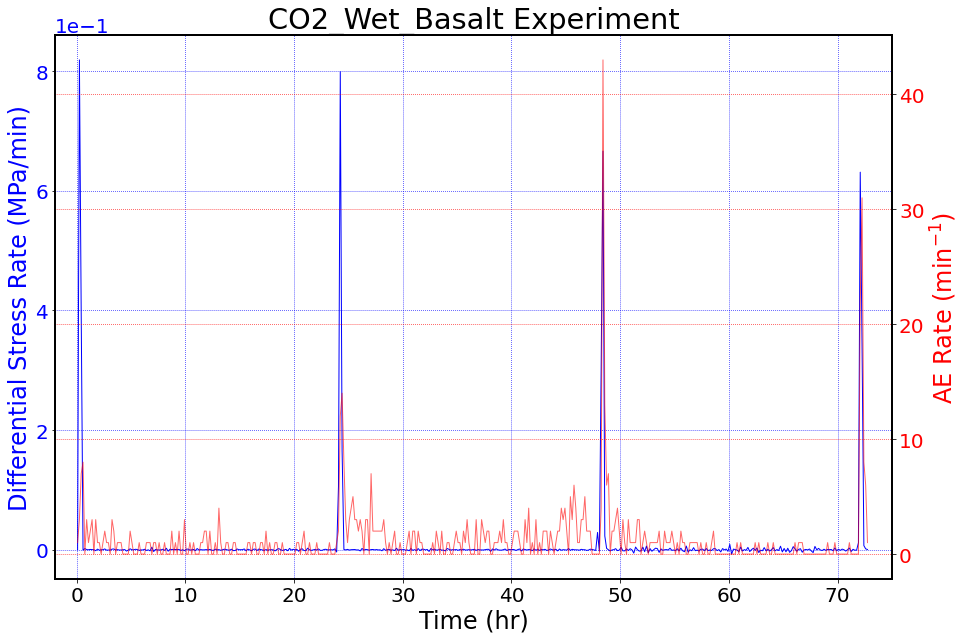

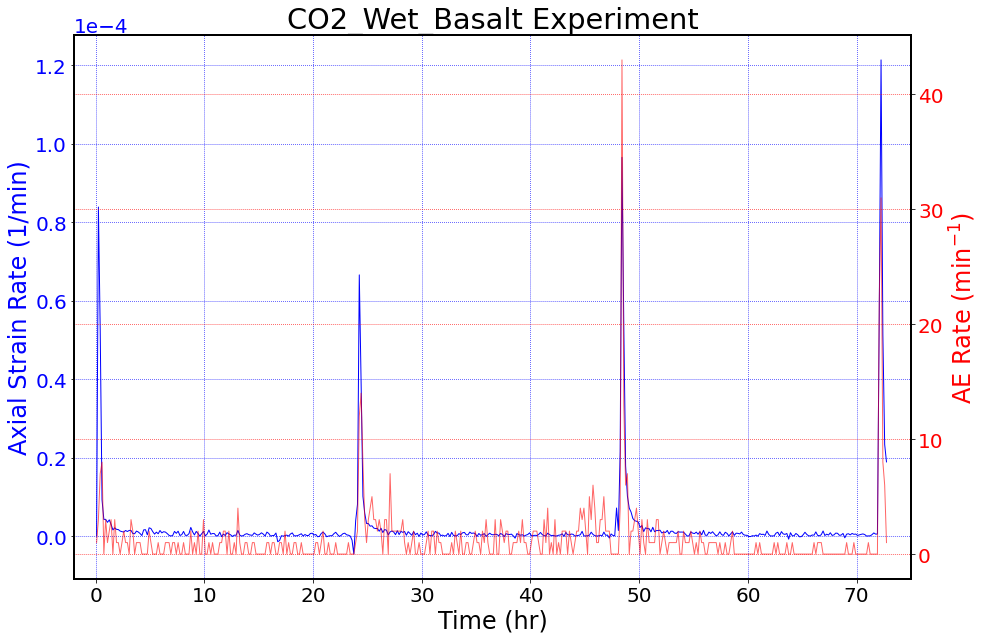

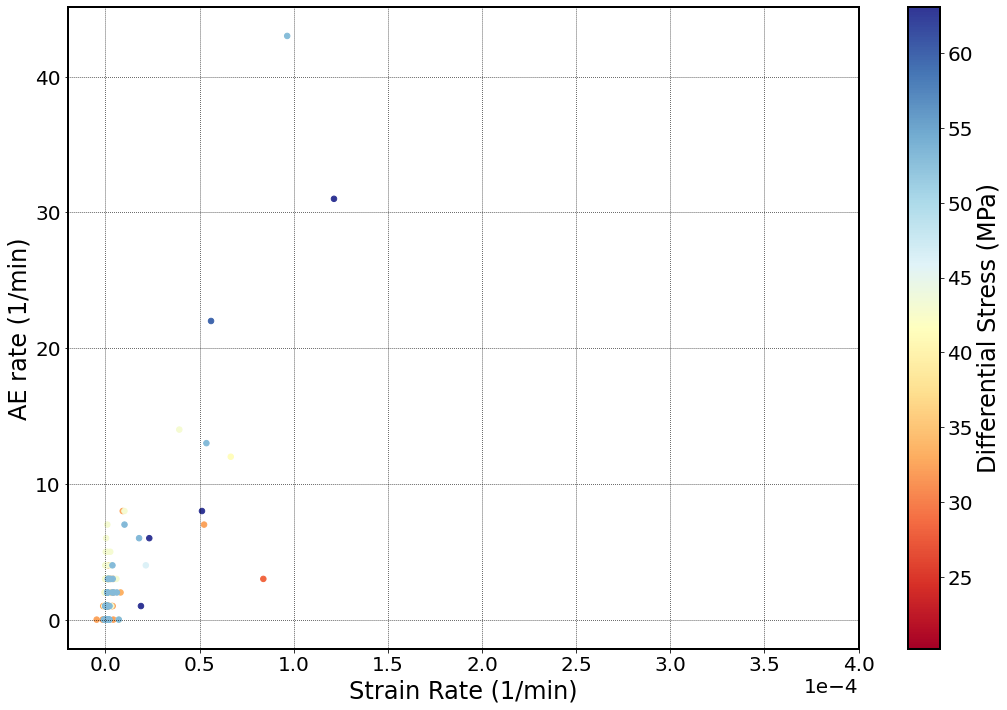

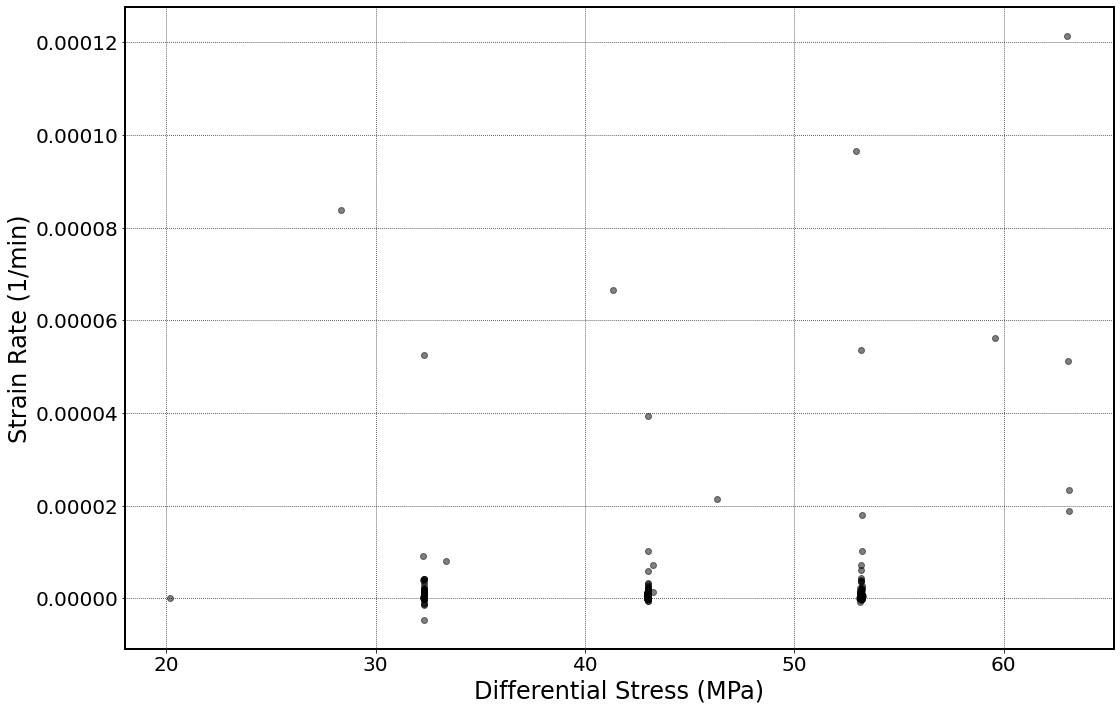

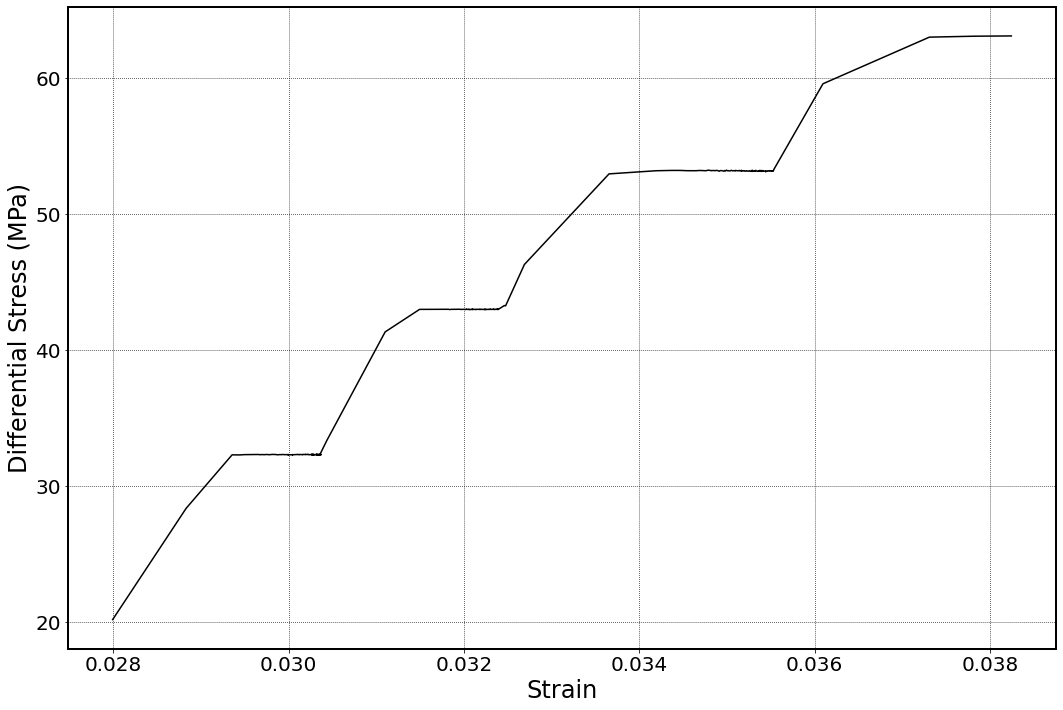

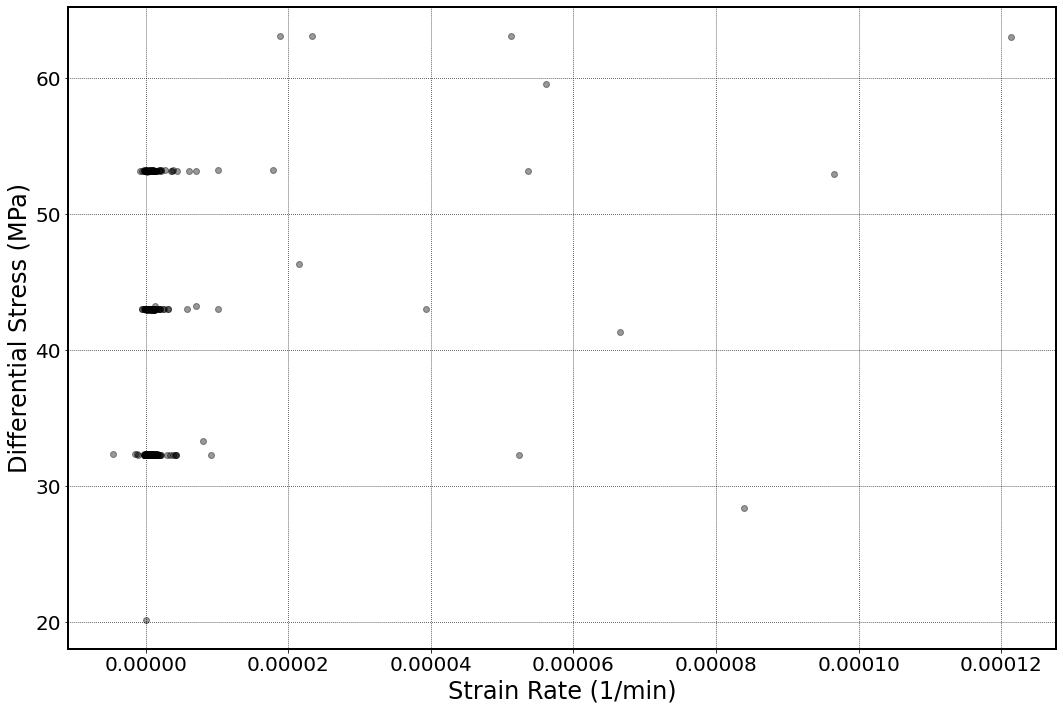

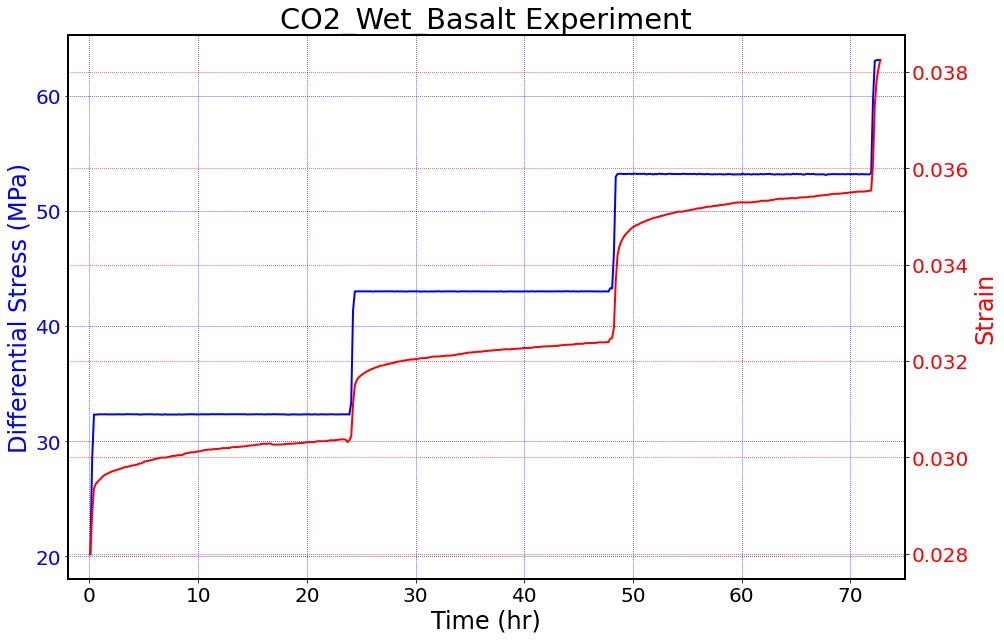

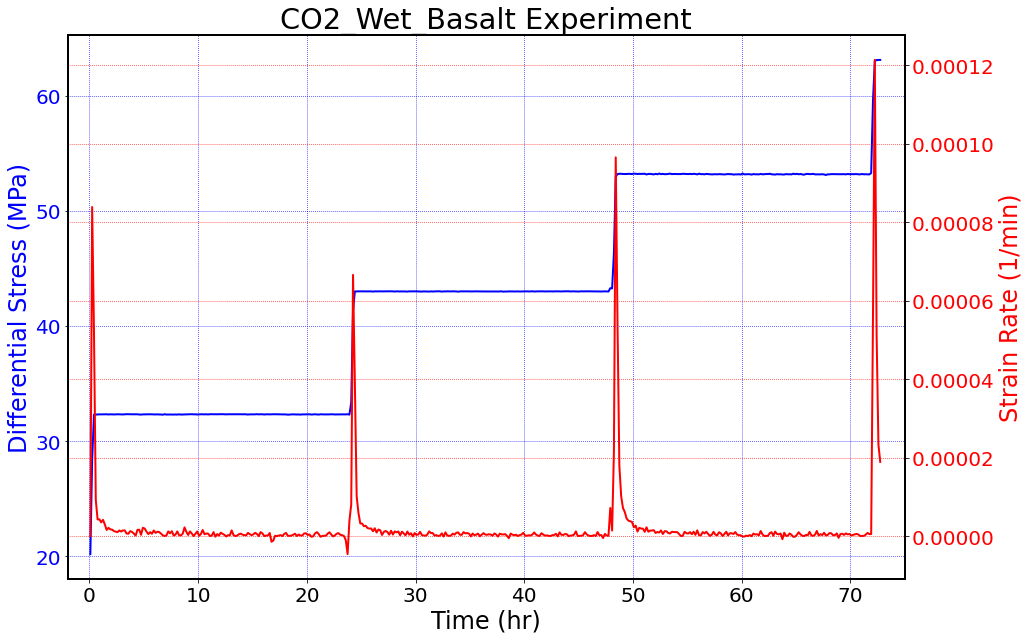

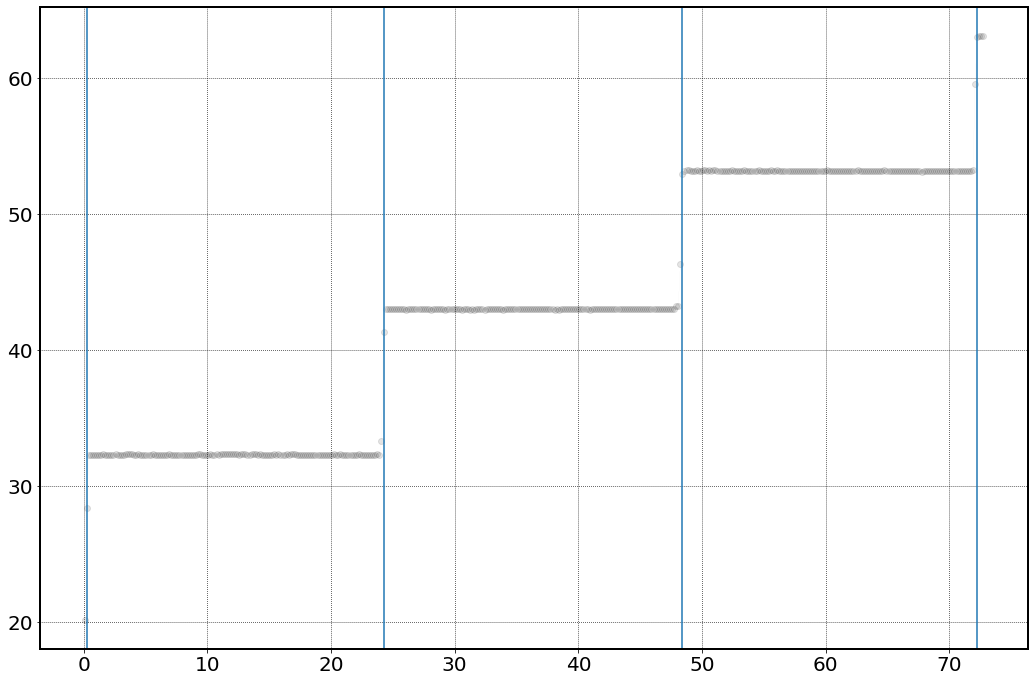

In [28]:
time_window = 600
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,
                              time_window,max_val=75,Temperature=False)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()
